# Introduction

Our target in this project was to build a model to predict default payment knowing some characteristics of the client. To do so, we had access to a dataset with 5380 client and 19 covariates (8 were categorial, 7 quantitative and 4 were dates) describing each client situation. To build our model we split the dataset in a training set on which we built our models and a test set. Our goal was to maximize the performances of the models on the test set without using these data for training our models. We used different metrics to compare the efficiency of our model. As the default payment represented less than 10% of the total client we used confusion matrix, AUC, ROC shape in addition to the most classical classification error. We filled missing values with -1 (as our quantitative covariates only take positive values). We used one-hot encoding to handle categorial covariates. Finally, before training we centered and scaled the train and test dataset. 

We trained and compared several models covering a large diversity of ML techniques:
- Random Forests
- LightGBM
- XGBoost
- CatBoost
- Fully Connected Neural Network
- Ridge classification
- Logistic Regression

When possible, we used Crossed Validation (on a parameter Grid) to optimize the hyper parameters.

We also compared the performances of our models when trained on more engineered datasets:
- While removing the covariates with less impact on our models
- While removing outliers
- By compensating the fact that "Non default payment clients" where far more numerous than "default payment clients" using oversampling, undersampling and a combination of both

Our approach followed the next setps:
- Data Reading, Preparation
- Exploratory Data Analysis
- First Machine Learning Models
- Machine Learning Models with Engineered datasets 
- Results Comparison


# 0. Data Reading, Preparation (and Packages)

We used one hot encoding to handle categorical data

In [0]:
!pip install catboost
!pip install scikit-plot

In [0]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import  MultipleLocator, FormatStrFormatter
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Lasso, LogisticRegression, RidgeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import scikitplot as skplt
from scipy import stats
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import xgboost
import lightgbm
import catboost

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
df = pd.read_csv('CreditTraining.csv')

In [0]:
# set boolean covariates for binary categorial ones
df['Customer_Type'] = df['Customer_Type'].str.contains("Non")
df['P_Client_2'] = df['P_Client']
df['P_Client'] = ~ df['P_Client'].str.contains("NP")
df['Source_2'] = df['Source']
df['Source'] = df['Source'].str.contains("Sales")
df = df.rename(columns={"Customer_Type":"New_Client", "Source":"Source_Sales"})

# one-hot encoding for non-binary categorial covariates
df['Educational_Level_2'] = df['Educational_Level']
df['Marital_Status_2'] = df['Marital_Status']
df['Prod_Sub_Category_2'] = df['Prod_Sub_Category']
df['Type_Of_Residence_2'] = df['Type_Of_Residence']
df['Prod_Category_2'] = df['Prod_Category']
df = pd.get_dummies(df, columns=['Educational_Level_2', 'Marital_Status_2', 'Prod_Sub_Category_2', 'Type_Of_Residence_2', 'Prod_Category_2'])

# convert date to numeric
df['BirthDate'] = pd.to_datetime(df['BirthDate'], dayfirst=True)
birthdate_index = pd.DatetimeIndex(df['BirthDate'])
df['BirthDate_Year'] = birthdate_index.year
df['BirthDate_Month'] = birthdate_index.month 
df['BirthDate_Day'] = birthdate_index.day 
df['BirthDate'] = df['BirthDate'].astype(int).astype(float)
df['Customer_Open_Date'] = pd.to_datetime(df['Customer_Open_Date'], dayfirst=True).astype(int).astype(float)
df['Prod_Decision_Date'] = pd.to_datetime(df['Prod_Decision_Date'], dayfirst=True).astype(int).astype(float)
df['Prod_Closed_Date'] = df['Prod_Closed_Date'].fillna(-1)
df['Prod_Closed_Date'] = pd.to_datetime(df['Prod_Closed_Date'], dayfirst=True) 
df['Prod_Closed_Date'] = df['Prod_Closed_Date'].astype(int).astype(float)

# convert string to numeric
df['Net_Annual_Income'] = df['Net_Annual_Income'].fillna(-1)
df['Net_Annual_Income'] = df['Net_Annual_Income'].str.replace(",",".").astype(float)

df.head()

,Id_Customer,Y,New_Client,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source_Sales,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category,P_Client_2,Source_2,Educational_Level_2_Diploma,Educational_Level_2_Master/PhD,Educational_Level_2_Secondary or Less,Educational_Level_2_University,Marital_Status_2_Divorced,Marital_Status_2_Married,Marital_Status_2_Separated,Marital_Status_2_Single,Marital_Status_2_Widowed,Prod_Sub_Category_2_C,Prod_Sub_Category_2_G,Prod_Sub_Category_2_P,Type_Of_Residence_2_Company,Type_Of_Residence_2_New rent,Type_Of_Residence_2_Old rent,Type_Of_Residence_2_Owned,Type_Of_Residence_2_Parents,Prod_Category_2_A,Prod_Category_2_B,Prod_Category_2_C,Prod_Category_2_D,Prod_Category_2_E,Prod_Category_2_F,Prod_Category_2_G,Prod_Category_2_H,Prod_Category_2_I,Prod_Category_2_J,Prod_Category_2_K,Prod_Category_2_L,Prod_Category_2_M,BirthDate_Year,BirthDate_Month,BirthDate_Day
0,7440,0,True,2.397600e+17,1.329091e+18,False,University,Married,3.0,1,36.0,1.0,C,1.329178e+18,True,Owned,1,-1.000000e+00,B,NP_Client,Sales,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1977,8,7
1,573,0,False,1.403136e+17,1.233706e+18,True,University,Married,0.0,12,18.0,2.0,C,1.309392e+18,True,Parents,1,-1.000000e+00,G,P_Client,Sales,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1974,6,13
2,9194,0,True,1.214784e+17,1.333411e+18,False,University,Married,2.0,10,36.0,1.0,C,1.333498e+18,True,Owned,1,-1.000000e+00,B,NP_Client,Sales,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1973,11,7
3,3016,1,False,3.949344e+17,1.314230e+18,False,University,Married,3.0,3,36.0,1.0,C,1.315354e+18,True,New rent,1,1.356912e+18,L,NP_Client,Sales,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1982,7,8
4,6524,0,True,-5.166720e+17,1.326154e+18,False,University,Married,2.0,1,36.0,1.0,C,1.326240e+18,True,Owned,1,-1.000000e+00,D,NP_Client,Sales,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1953,8,18


# 1. Exploratory Data Analysis

As with any project involving data, we began by analyzing the data to identify initial characteristics that could be useful later on.

We first looked at the  distribution between default payment client and non default payment clients to see that no default payment clients were largely more numerous.

## Type of Client

In [0]:
df_default = df[df['Y'] == 1]
df_no_default = df[df['Y'] == 0]

<Figure size 432x288 with 0 Axes>

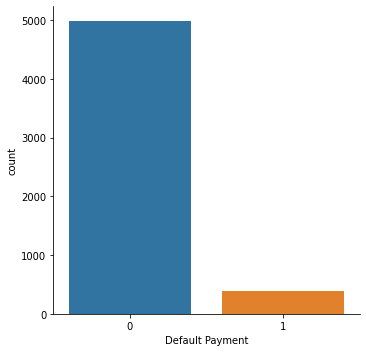

In [0]:
plt.figure()
sns.catplot(x='Y',data=df,  kind="count").set_axis_labels("Default Payment","count")
plt.show()

## Correlation Matrix

We then looked at the correlations between the variables. The goal of this was to possibly have an overview of the explanability of our covariates towards Default Payment. Unfortunately they wasn't any high correlation between our covariates and Y.

[]

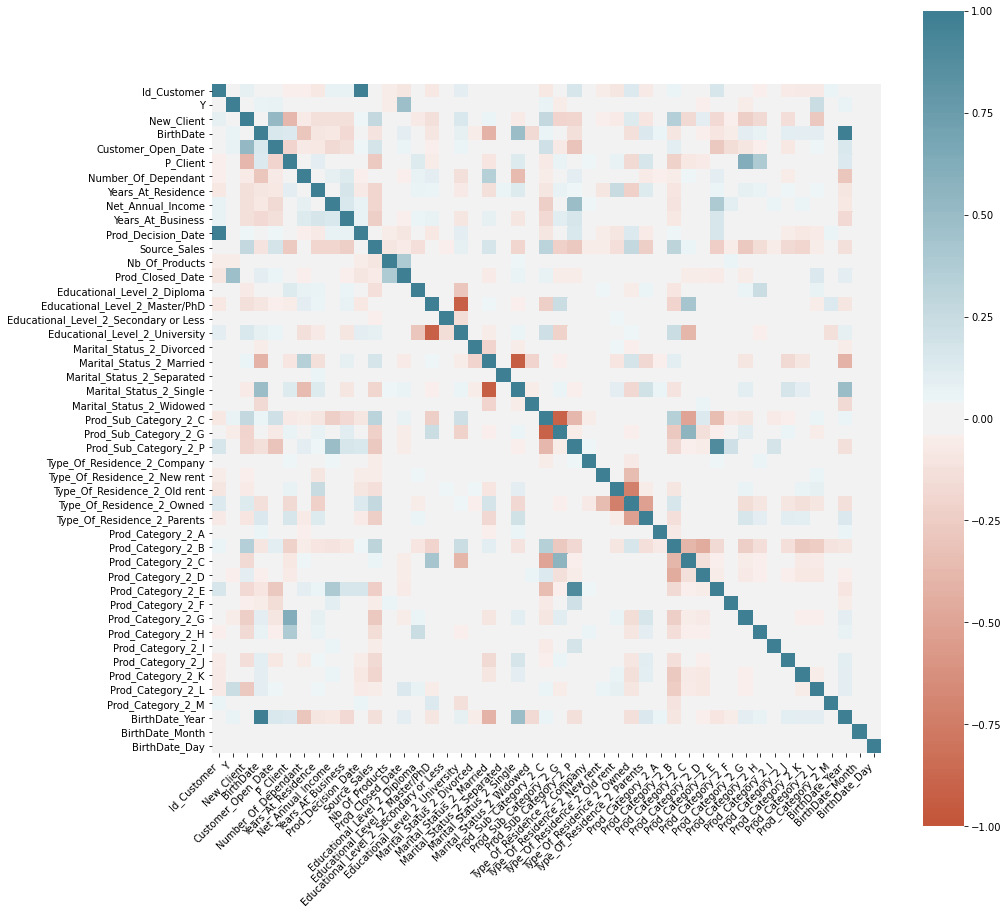

In [0]:
plt.figure(figsize=(15,15))
correlation = df.corr()
ax = sns.heatmap(correlation, vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 square=True) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.plot()

[]

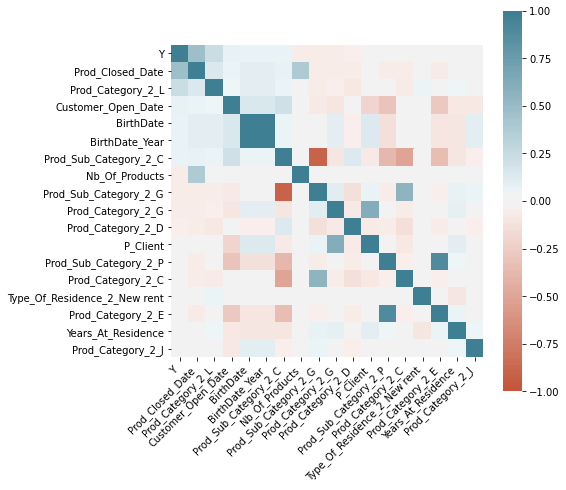

In [0]:
plt.figure(figsize=(7,7))
indexCorr = abs(df.corr()['Y']).sort_values(ascending=False).index[:18]
dfCorr = df[indexCorr]
corrY = dfCorr.corr()
ax2 = sns.heatmap(corrY, vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 square=True) 
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.plot()

## Other covariates analysis

Lastly, we plot graphs for each covariates to evaluate the distribution of default and non-default clients, according to these covariates.

### Client Categorization

<Figure size 432x288 with 0 Axes>

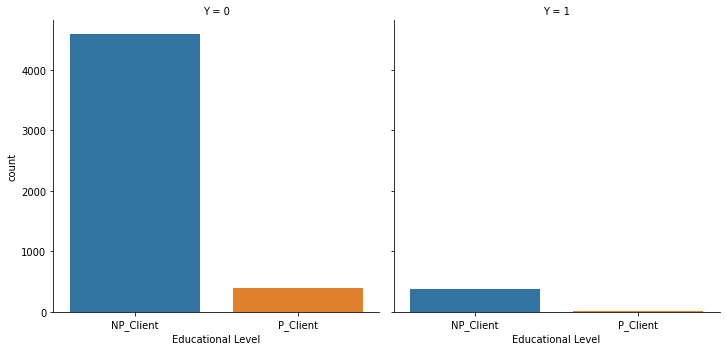

In [0]:
plt.figure()
sns.catplot(x='P_Client_2',data=df, col='Y', kind="count").set_axis_labels("Educational Level","count")
plt.show()

### Year of Birth

<Figure size 432x288 with 0 Axes>

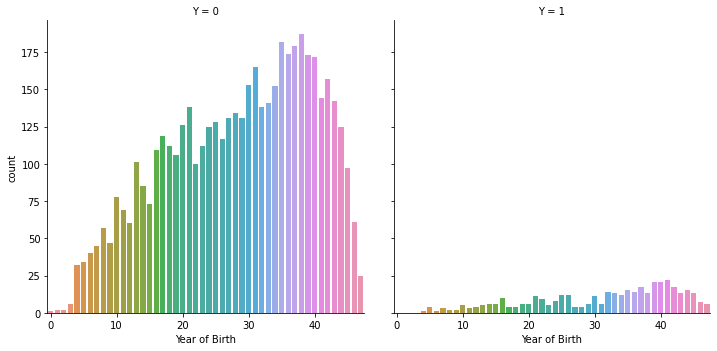

In [0]:
plt.figure()
sns.catplot(x='BirthDate_Year',data=df, col='Y', kind="count").set_axis_labels("Year of Birth","count")
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

### Month of Birth

<Figure size 432x288 with 0 Axes>

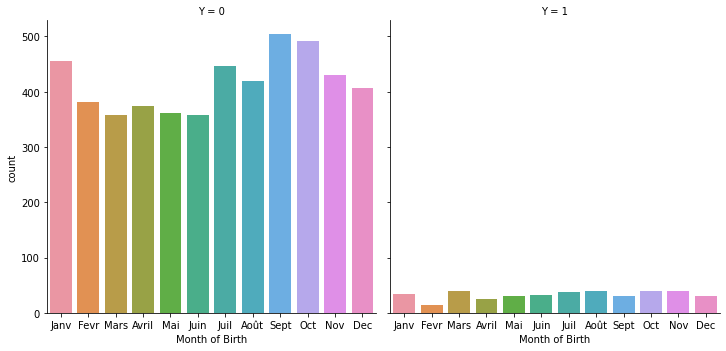

In [0]:
plt.figure()
sns.catplot(x='BirthDate_Month',data=df, col='Y', kind="count").set_axis_labels("Month of Birth","count")
plt.gca().set_xticklabels(['Janv', 'Fevr', 'Mars', 'Avril', 'Mai', 'Juin', 'Juil', 'Août', 'Sept', 'Oct', 'Nov', 'Dec'])
plt.show()

### Day of Birth

<Figure size 432x288 with 0 Axes>

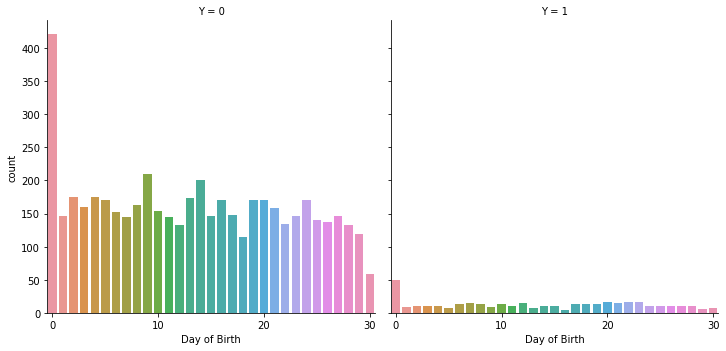

In [0]:
plt.figure()
sns.catplot(x='BirthDate_Day',data=df, col='Y', kind="count").set_axis_labels("Day of Birth","count")
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

### Educational Level

<Figure size 432x288 with 0 Axes>

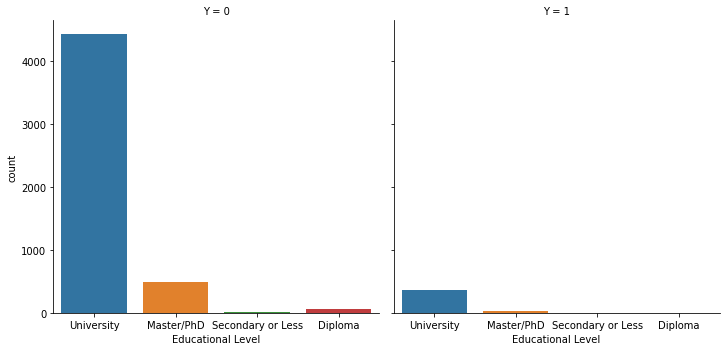

In [0]:
plt.figure()
sns.catplot(x='Educational_Level',data=df, col='Y', kind="count").set_axis_labels("Educational Level","count")
plt.show()

### Marital Status

<Figure size 432x288 with 0 Axes>

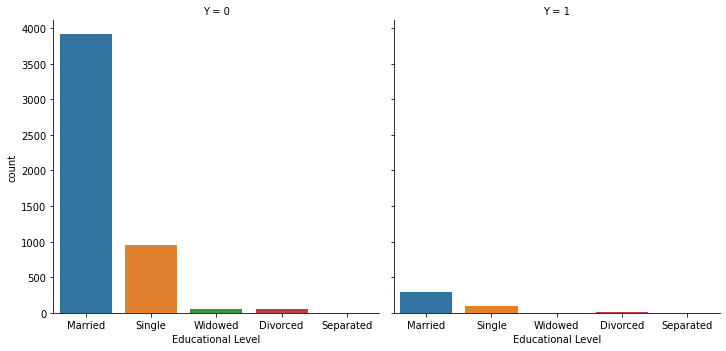

In [0]:
plt.figure()
sns.catplot(x='Marital_Status',data=df, col='Y', kind="count").set_axis_labels("Educational Level","count")
plt.show()

### Net Annual Income

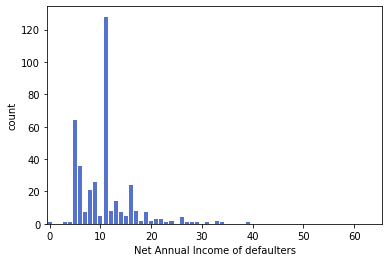

In [0]:
plt.figure()
bins = np.arange(0, 200, 3)
binned = pd.cut(df_default['Net_Annual_Income'], bins, labels=bins[:-1], include_lowest=True)
sns.countplot(binned, color='royalblue')
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.xlabel("Net Annual Income of defaulters")
plt.show()

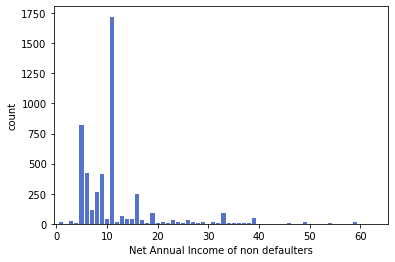

In [0]:
plt.figure()
bins = np.arange(0, 200, 3)
binned = pd.cut(df_no_default['Net_Annual_Income'], bins, labels=bins[:-1], include_lowest=True)
sns.countplot(binned, color='royalblue')
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.xlabel("Net Annual Income of non defaulters")
plt.show()

### Type of Residence

<Figure size 432x288 with 0 Axes>

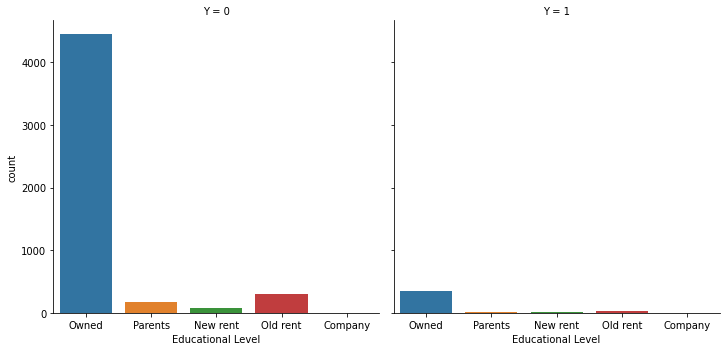

In [0]:
plt.figure()
sns.catplot(x='Type_Of_Residence',data=df, col='Y', kind="count").set_axis_labels("Educational Level","count")
plt.show()

### Years at Residence

<Figure size 432x288 with 0 Axes>

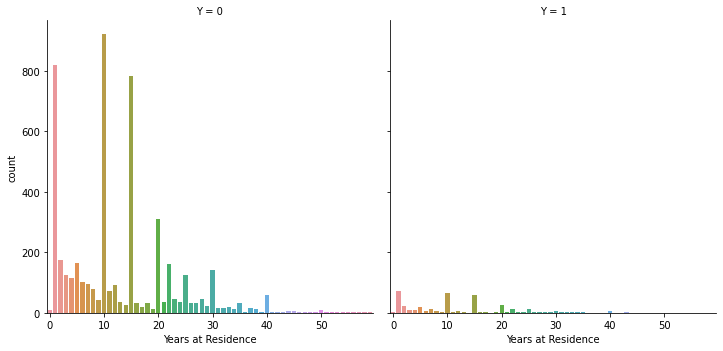

In [0]:
plt.figure()
sns.catplot(x='Years_At_Residence',data=df, col='Y', kind="count").set_axis_labels("Years at Residence","count")
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

### Years At Business

<Figure size 432x288 with 0 Axes>

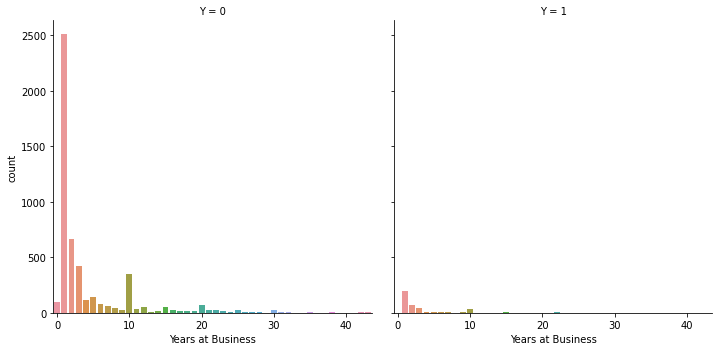

In [0]:
plt.figure()
sns.catplot(x='Years_At_Business',data=df, col='Y', kind="count").set_axis_labels("Years at Business","count")
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

### Number of Products

<Figure size 432x288 with 0 Axes>

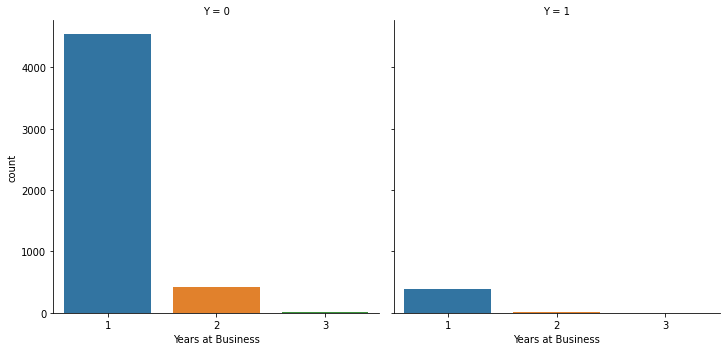

In [0]:
plt.figure()
sns.catplot(x='Nb_Of_Products',data=df, col='Y', kind="count").set_axis_labels("Years at Business","count")
plt.show()

### Financing Source

<Figure size 432x288 with 0 Axes>

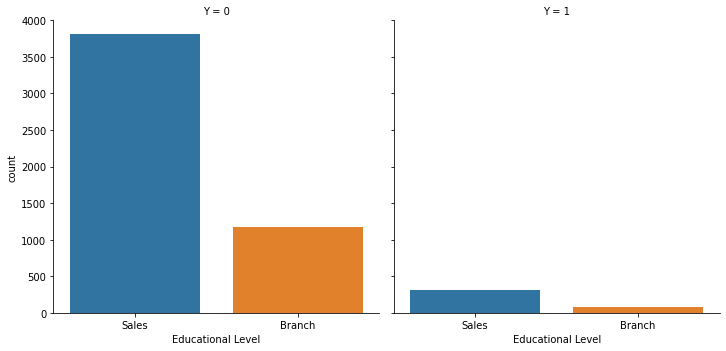

In [0]:
plt.figure()
sns.catplot(x='Source_2',data=df, col='Y', kind="count").set_axis_labels("Educational Level","count")
plt.show()

### Product Category

<Figure size 432x288 with 0 Axes>

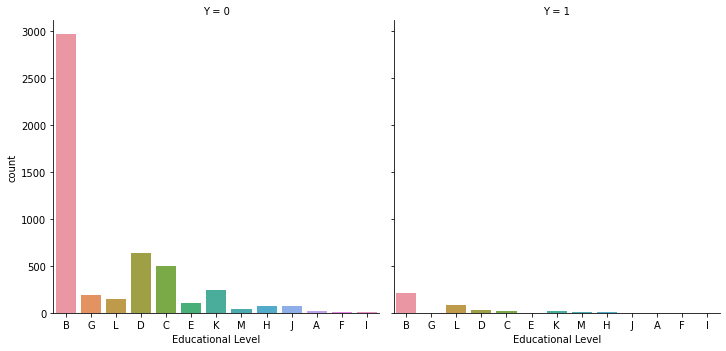

In [0]:
plt.figure()
sns.catplot(x='Prod_Category',data=df, col='Y', kind="count").set_axis_labels("Educational Level","count")
plt.show()

### Product Sub-Category

<Figure size 432x288 with 0 Axes>

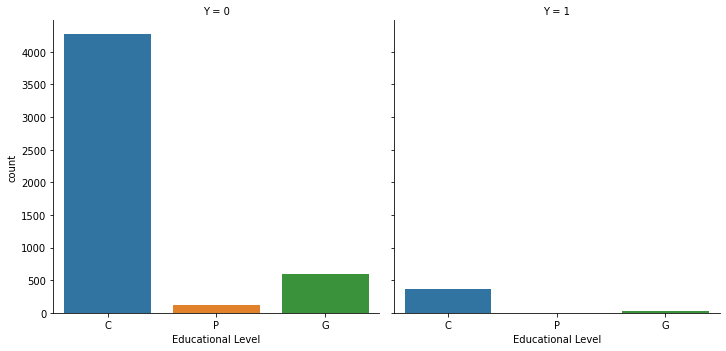

In [0]:
plt.figure()
sns.catplot(x='Prod_Sub_Category',data=df, col='Y', kind="count").set_axis_labels("Educational Level","count")
plt.show()

### Number of Dependant

<Figure size 432x288 with 0 Axes>

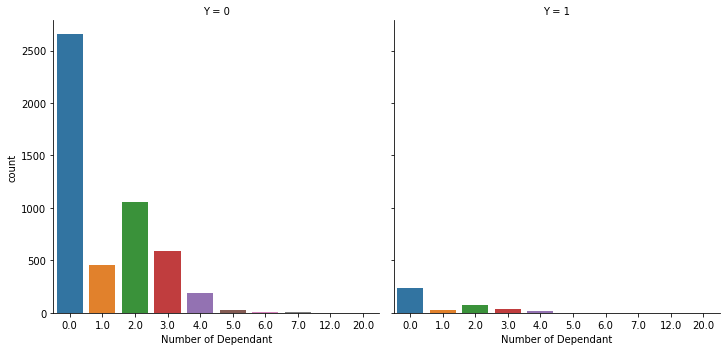

In [0]:
plt.figure()
sns.catplot(x='Number_Of_Dependant',data=df, col='Y', kind="count").set_axis_labels("Number of Dependant","count")
plt.show()

## Imputation of missing Data

We filled missing data with -1.

In [0]:
Y = df['Y']
df['Number_Of_Dependant'] = df['Number_Of_Dependant'].fillna(-1)
df['Net_Annual_Income'] = df['Net_Annual_Income'].fillna(-1)
df['Years_At_Business'] = df['Years_At_Business'].fillna(-1)

## Drop initial categorical data after one hot encoding 

In [0]:
df_dropped = df.drop(['Y', 'Id_Customer', 'Educational_Level', 'Marital_Status', 'Prod_Sub_Category', 'Prod_Category', 'Type_Of_Residence', 'P_Client_2', 'Source_2', 'BirthDate_Day', 'BirthDate_Month', 'BirthDate_Year'], axis=1)

## Split between Train and Test set

We split the available data: 
- 80% for train set
- 20% for test set

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(df_dropped,Y,test_size= int(len(df_dropped.index)*0.2),random_state=11)

# 2. First Machine Learning Models

We decided to use different models seen in class to classify default payment. 
We started by centering and scaling our data.
Then for each model we optimized the hyper parameters using cross validation on the training set. Once we had access to these "optimal hyperparameters", we trained our models and checked their performances on the test set. These performances were compared using classification error, AUC, ROC shape, Gini indice and learning times.

## 2.0 Final data preprocessing

Data normalization (important for some none linear methods):

In [0]:
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

Creation of lists to gather results:

In [0]:
resultsTrain = []
results = []
gini = []
runtimes = []
results_labels = []

resultsRF = []
giniRF = []
results_labelsRF = []

resultsLGBM = []
giniLGBM = []
results_labelsLGBM = []

resultsRidge = []
giniRidge = []
results_labelsRidge = []

In [0]:
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true

## 2.1 Random Forest

A first model:

In [0]:
# parameters definition
rf = RandomForestClassifier(bootstrap=True, oob_score=True)
# learning
rfFit = rf.fit(X_train,Y_train)
print(1-rfFit.oob_score_)

0.050882899628252765


In [0]:
# prediction error on the test set
1-rfFit.score(X_test,Y_test)

0.06133828996282531

Optimization by cross-valuation of the number of variables randomly drawn during the construction of each node:

In [0]:
param=[{"max_features":list(range(2,10,1)), "n_estimators":range(1,101,10)}]
rf= GridSearchCV(RandomForestClassifier(),
        param,cv=5,n_jobs=-1)
rfOpt=rf.fit(X_train, Y_train)
# optimal parameters
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

Meilleur score = 0.047630, Meilleur paramètre = {'max_features': 9, 'n_estimators': 41}


Best model :

In [0]:
t0 = time.time()
rf = RandomForestClassifier(n_estimators=21, max_features=9)
rfFit = rf.fit(X_train, Y_train)
runtimes.append(time.time() - t0)
1 - rfFit.score(X_train,Y_train)

0.0016263940520445663

Results storage:

In [0]:
result_rf = 1-rfFit.score(X_test,Y_test)
print(result_rf)

Y_pred_rf = rfFit.predict(X_test)

resultsTrain.append(1 - rfFit.score(X_train,Y_train))
results.append(result_rf)
gini.append(Gini(Y_test,Y_pred_rf))
results_labels.append('RF')

resultsRF.append(result_rf)
giniRF.append(Gini(Y_test,Y_pred_rf))
results_labelsRF.append('RF')

0.059479553903345694


Features importance:

In [0]:
# Decreasing features importance
importances_rf = rfFit.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
for f in range(X_train.shape[1]):
    print(df_dropped.columns[indices_rf[f]], importances_rf[indices_rf[f]])

Prod_Closed_Date 0.3517374156558836
BirthDate 0.10166160635606629
Customer_Open_Date 0.09759958127855964
Prod_Decision_Date 0.08754043201046784
Years_At_Residence 0.05845055114442094
Net_Annual_Income 0.05142534601255294
Nb_Of_Products 0.046647881944442804
Prod_Category_2_L 0.03897555119331183
Years_At_Business 0.031136681300257183
Number_Of_Dependant 0.026821639078409006
Source_Sales 0.012538475368499865
New_Client 0.01073554482124647
Prod_Category_2_B 0.010392504238846426
Marital_Status_2_Married 0.00781101814674058
Educational_Level_2_Master/PhD 0.007264225826869932
Marital_Status_2_Single 0.007220954700970574
Prod_Category_2_D 0.005253941302861899
Prod_Category_2_K 0.0052299334411001555
Educational_Level_2_University 0.004428100607117664
Prod_Sub_Category_2_G 0.00424271642639952
Type_Of_Residence_2_Old rent 0.0041970950280808255
Type_Of_Residence_2_Owned 0.004188306295173895
Prod_Sub_Category_2_C 0.003690913202651933
Prod_Category_2_H 0.0031509526671672757
Type_Of_Residence_2_New r

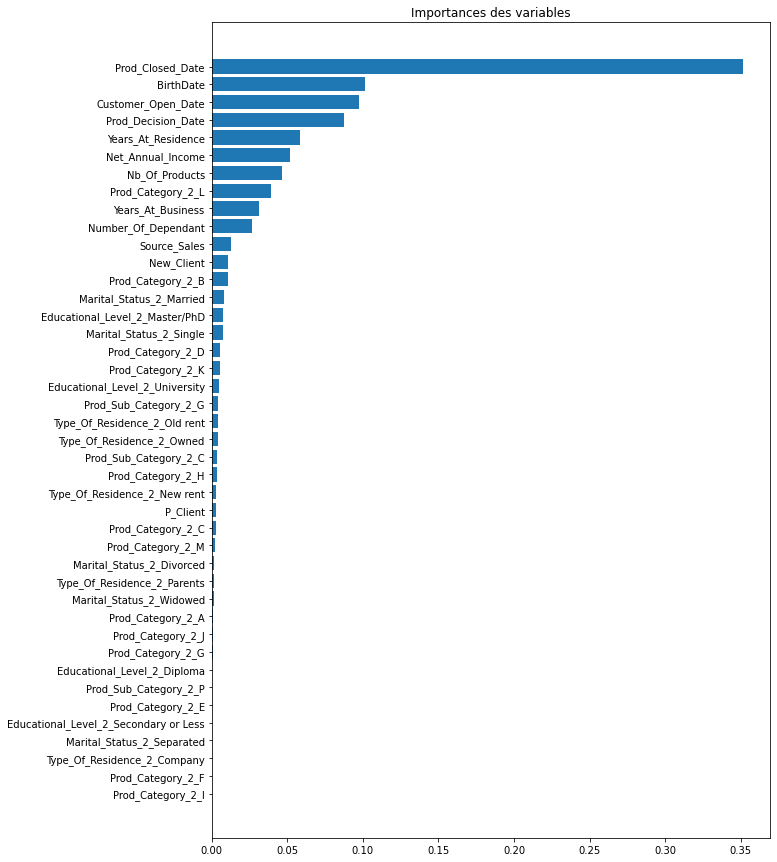

In [0]:
plt.figure(figsize=(10,15))
plt.title("Importances des variables")
plt.barh(range(X_train.shape[1]), importances_rf[indices_rf][::-1], align='center')
plt.yticks(range(X_train.shape[1]), [df_dropped.columns[i] for i in indices_rf[::-1]])
plt.show()

## 2.2 XGBoost

A first model:

In [0]:
xgb = xgboost.XGBClassifier()
xgbFit = xgb.fit(X_train, Y_train)
print(1 - xgbFit.score(X_train,Y_train))

0.029972118959107785


In [0]:
# prediction error on the test set
1-xgbFit.score(X_test,Y_test)

0.0492565055762082

Optimization by cross validation of maximum depth of trees :

In [0]:
param=[{"max_depth":list(range(2,11,1))}]
xgb= GridSearchCV(xgboost.XGBClassifier(),
        param,cv=5,n_jobs=-1)
xgbOpt=xgb.fit(X_train, Y_train)
# optimal parameter
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - xgbOpt.best_score_,xgbOpt.best_params_))

Meilleur score = 0.042752, Meilleur paramètre = {'max_depth': 5}


Best model:

In [0]:
t0 = time.time()
xgb = xgboost.XGBClassifier(max_depth = 5)
xgbFit = xgb.fit(X_train, Y_train)
runtimes.append(time.time() - t0)
print(1 - xgbFit.score(X_train,Y_train))

0.015334572490706355


Results storage:

In [0]:
result_xgb = 1-xgbFit.score(X_test,Y_test)
print(result_xgb)

Y_pred_xgb = xgbFit.predict(X_test)
resultsTrain.append(1 - xgbFit.score(X_train,Y_train))
results.append(result_xgb)
gini.append(Gini(Y_test, Y_pred_xgb))
results_labels.append('XGB')

0.048327137546468446


Features importance:

In [0]:
# Decreasing features importance
importances_xgb = xgbFit.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
for f in range(X_train.shape[1]):
    print(df_dropped.columns[indices_xgb[f]], importances_xgb[indices_xgb[f]])

Nb_Of_Products 0.23660943
Prod_Closed_Date 0.1678234
Prod_Category_2_L 0.061766732
Type_Of_Residence_2_New rent 0.047936246
Prod_Category_2_C 0.040614076
Prod_Category_2_K 0.038216446
Customer_Open_Date 0.032978863
Source_Sales 0.03240792
Educational_Level_2_Master/PhD 0.027925165
P_Client 0.027011812
BirthDate 0.02621766
Years_At_Residence 0.025423586
Educational_Level_2_University 0.024656916
Prod_Decision_Date 0.023965394
Marital_Status_2_Married 0.023653476
Net_Annual_Income 0.022129748
New_Client 0.020197714
Prod_Category_2_D 0.01900483
Number_Of_Dependant 0.017750742
Years_At_Business 0.017251845
Prod_Category_2_B 0.016168006
Type_Of_Residence_2_Owned 0.015532744
Prod_Category_2_H 0.013436358
Prod_Category_2_G 0.009161893
Prod_Sub_Category_2_G 0.009063639
Marital_Status_2_Single 0.003095308
Educational_Level_2_Diploma 0.0
Prod_Category_2_M 0.0
Educational_Level_2_Secondary or Less 0.0
Marital_Status_2_Divorced 0.0
Marital_Status_2_Separated 0.0
Prod_Sub_Category_2_C 0.0
Prod_Sub_

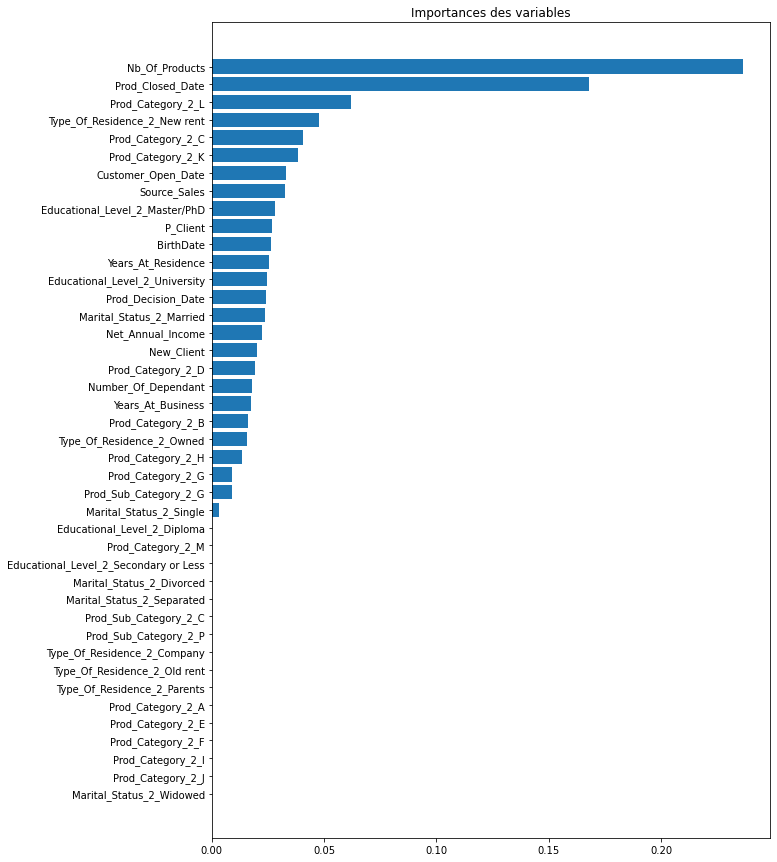

In [0]:
plt.figure(figsize=(10,15))
plt.title("Importances des variables")
plt.barh(range(X_train.shape[1]), importances_xgb[indices_xgb][::-1], align='center')
plt.yticks(range(X_train.shape[1]), [df_dropped.columns[i] for i in indices_xgb[::-1]])
plt.show()

## 2.3 LightGBM

A first model:

In [0]:
lgbm = lightgbm.LGBMClassifier()
lgbmFit = lgbm.fit(X_train, Y_train)
print(1 - lgbmFit.score(X_train,Y_train))

0.00023234200743493805


In [0]:
# prediction error on the test set
1-lgbmFit.score(X_test,Y_test)

0.04646840148698883

Optimization by cross validation of maximum depth of trees :

In [0]:
param=[{"max_depth":list(range(2,11,1))}]
lgbm= GridSearchCV(lightgbm.LGBMClassifier(),
        param,cv=5,n_jobs=-1)
lgbmOpt=lgbm.fit(X_train, Y_train)
# optimal parameter
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - lgbmOpt.best_score_,lgbmOpt.best_params_))

Meilleur score = 0.041125, Meilleur paramètre = {'max_depth': 7}


Best model:

In [0]:
t0 = time.time()
lgbm = lightgbm.LGBMClassifier(max_depth = 7)
lgbmFit = lgbm.fit(X_train, Y_train)
runtimes.append(time.time() - t0)
print(1 - lgbmFit.score(X_train,Y_train))

0.003949814126394058


Results storage:

In [0]:
result_lgbm = 1-lgbmFit.score(X_test,Y_test)
print(result_lgbm)

Y_pred_lgbm = lgbmFit.predict(X_test)

resultsTrain.append(1 - lgbmFit.score(X_train,Y_train))
results.append(result_lgbm)
gini.append(Gini(Y_test, Y_pred_lgbm))
results_labels.append('LGBM')

resultsLGBM.append(result_lgbm)
giniLGBM.append(Gini(Y_test, Y_pred_lgbm))
results_labelsLGBM.append('LGBM')

0.04646840148698883


Features importance:

In [0]:
# Decreasing features importance
importances_lgbm = lgbmFit.feature_importances_
importances_lgbm = importances_lgbm/importances_lgbm.sum()
indices_lgbm = np.argsort(importances_lgbm)[::-1]
for f in range(X_train.shape[1]):
    print(df_dropped.columns[indices_lgbm[f]], importances_lgbm[indices_lgbm[f]])

BirthDate 0.18204758471521268
Prod_Decision_Date 0.15897620764239365
Prod_Closed_Date 0.15392934390771448
Customer_Open_Date 0.14419610670511895
Years_At_Residence 0.09480894015861571
Net_Annual_Income 0.07281903388608507
Years_At_Business 0.05227108868060562
Number_Of_Dependant 0.03857245854361932
Prod_Category_2_L 0.014419610670511895
Nb_Of_Products 0.014059120403749098
Source_Sales 0.009372746935832732
New_Client 0.00829127613554434
Prod_Category_2_D 0.007209805335255948
Marital_Status_2_Married 0.00684931506849315
Prod_Category_2_B 0.005767844268204758
Prod_Category_2_K 0.005407354001441961
Prod_Category_2_H 0.005046863734679163
Type_Of_Residence_2_Owned 0.004325883201153569
Educational_Level_2_Master/PhD 0.003604902667627974
Educational_Level_2_University 0.002883922134102379
Marital_Status_2_Single 0.0021629416005767843
Prod_Category_2_C 0.0021629416005767843
P_Client 0.0021629416005767843
Prod_Category_2_G 0.0021629416005767843
Type_Of_Residence_2_Parents 0.001802451333813987
Pr

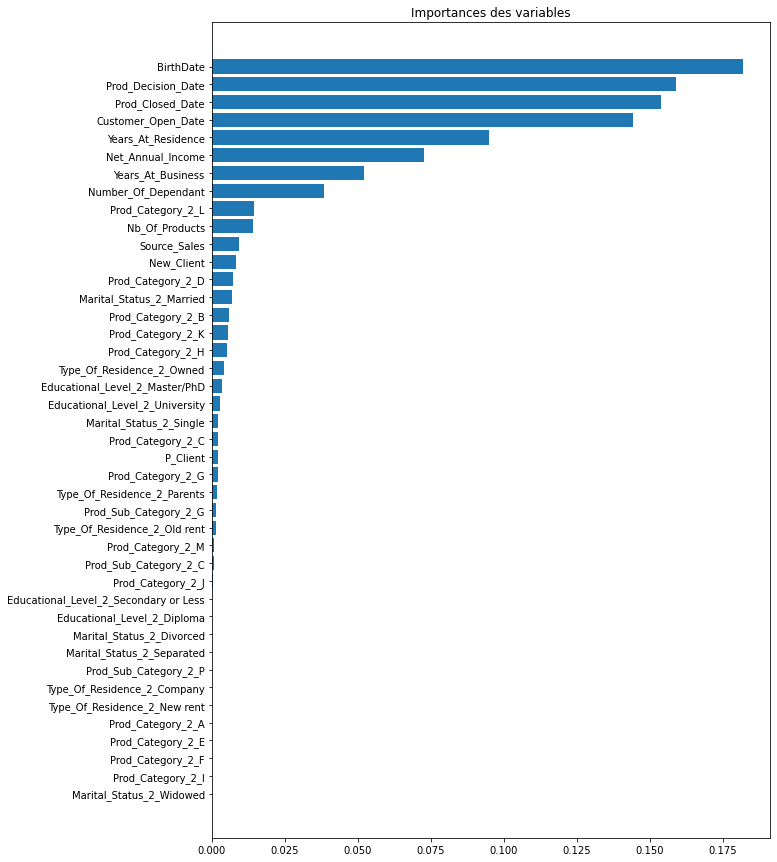

In [0]:
plt.figure(figsize=(10,15))
plt.title("Importances des variables")
plt.barh(range(X_train.shape[1]), importances_lgbm[indices_lgbm][::-1], align='center')
plt.yticks(range(X_train.shape[1]), [df_dropped.columns[i] for i in indices_lgbm[::-1]])
plt.show()

## 2.4 Catboost

A first model:

In [0]:
catb = catboost.CatBoostClassifier()
catbFit = catb.fit(X_train, Y_train, verbose = False)
print(1 - catbFit.score(X_train,Y_train))

0.01231412639405205


In [0]:
# prediction error on the test set
1-catbFit.score(X_test,Y_test)

0.04739776951672858

Optimization by cross validation of maximum depth of trees :

In [0]:
param=[{"depth":list(range(2,11,1))}]
catb= GridSearchCV(catboost.CatBoostClassifier(),
        param,cv=5,n_jobs=-1)
catbOpt=catb.fit(X_train, Y_train, verbose = False)
# optimal parameter
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - catbOpt.best_score_,catbOpt.best_params_))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Meilleur score = 0.040893, Meilleur paramètre = {'depth': 7}


Best model:

In [0]:
t0 = time.time()
catb = catboost.CatBoostClassifier(depth = 7)
catbFit = catb.fit(X_train, Y_train, verbose = False)
runtimes.append(time.time() - t0)
print(1 - catbFit.score(X_train,Y_train))

0.009293680297397744


Results storage:

In [0]:
result_catb = 1-catbFit.score(X_test,Y_test)
print(result_catb)

Y_pred_catb = catb.predict(X_test)
resultsTrain.append(1 - catbFit.score(X_train,Y_train))
results.append(result_catb)
gini.append(Gini(Y_test, Y_pred_catb))
results_labels.append('CatBoost')

0.04739776951672858


Features importance:

In [0]:
# Decreasing features importance
importances_catb = catbFit.feature_importances_
importances_catb = importances_catb / importances_catb.sum()
indices_catb = np.argsort(importances_catb)[::-1]
for f in range(X_train.shape[1]):
    print(df_dropped.columns[indices_catb[f]], importances_catb[indices_catb[f]])

Prod_Closed_Date 0.2904705327724583
Prod_Decision_Date 0.09969437302410755
BirthDate 0.09785838236804041
Customer_Open_Date 0.0961008715071219
Years_At_Residence 0.07357838423990919
Net_Annual_Income 0.06936785550088033
Nb_Of_Products 0.05554353425806963
Number_Of_Dependant 0.045475562030245595
Years_At_Business 0.02721966787594615
Prod_Category_2_L 0.023497418403144222
New_Client 0.021288524005206057
Prod_Category_2_B 0.018190114883534725
Source_Sales 0.01787332353962265
Marital_Status_2_Married 0.009751356921514756
Educational_Level_2_University 0.008379829739458527
Type_Of_Residence_2_Owned 0.0060874876553858965
P_Client 0.0056369198136123665
Marital_Status_2_Single 0.004308845056891885
Educational_Level_2_Master/PhD 0.0036481165614017006
Prod_Category_2_D 0.0035498306473805653
Prod_Sub_Category_2_G 0.0029574576843643435
Type_Of_Residence_2_Old rent 0.0029005212989411666
Prod_Category_2_H 0.002854365432120891
Prod_Category_2_K 0.0028127480388106195
Prod_Sub_Category_2_C 0.0023044357

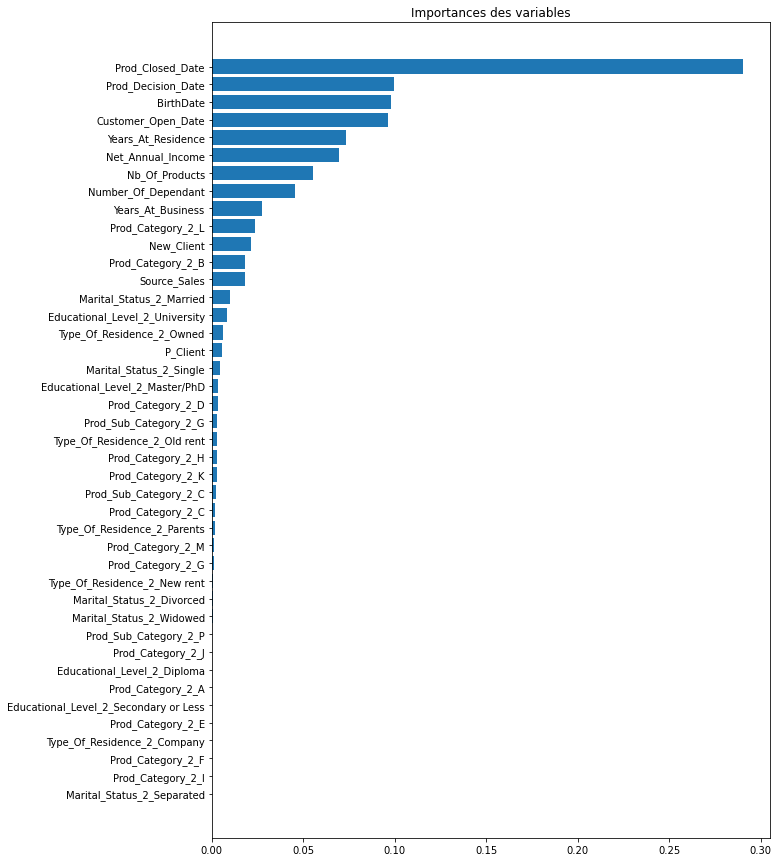

In [0]:
plt.figure(figsize=(10,15))
plt.title("Importances des variables")
plt.barh(range(X_train.shape[1]), importances_catb[indices_catb][::-1], align='center')
plt.yticks(range(X_train.shape[1]), [df_dropped.columns[i] for i in indices_catb[::-1]])
plt.show()

## 2.5 Neural Network

A first model:

In [0]:
nnet = MLPClassifier()
nnetOpt = nnet.fit(X_train,Y_train)
print(1-nnetOpt.score(X_train,Y_train))

0.027416356877323467


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [0]:
# prediction error on the test set 
1-nnetOpt.score(X_test,Y_test)

0.0780669144981413

Optimization by cross validation of number of hidden layers:

In [0]:
param_grid=[{"hidden_layer_sizes":list([(5,),(8,),(10,)])}]
nnet= GridSearchCV(MLPClassifier(max_iter=700),param_grid,cv=10,n_jobs=-1)
nnetOpt=nnet.fit(X_train, Y_train)
# optimal parameter
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - nnetOpt.best_score_,nnetOpt.best_params_))

Meilleur score = 0.066913, Meilleur paramètre = {'hidden_layer_sizes': (5,)}


Best model:

In [0]:
t0 = time.time()
nnet = MLPClassifier(max_iter=700, hidden_layer_sizes=(5, ))
nnetOpt=nnet.fit(X_train, Y_train)
runtimes.append(time.time() - t0)

# Estimation de l'erreur de prévision sur le test
result_nn = 1-nnetOpt.score(X_test,Y_test)
print(result_nn)

Y_pred_nn = nnet.predict(X_test)
resultsTrain.append(1-nnetOpt.score(X_train,Y_train))
results.append(result_nn)
gini.append(Gini(Y_test, Y_pred_nn))
results_labels.append('NN')

0.0780669144981413


In [0]:
# prévision de l'échantillon test
y_pred = nnetOpt.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_pred,Y_test)
print(table)

Y        0   1
row_0         
0      968  63
1       21  24


## 2.6 Ridge

In [0]:
# parameters definition
ridge = RidgeClassifier(alpha=1, fit_intercept=True, normalize=False)

In [0]:
# learning
ridgeFit = ridge.fit(X_train,Y_train)
print(1-ridgeFit.score(X_train,Y_train))

0.06110594795539037


Optimization by cross validation of the regularization parameter:


In [0]:
param=[{"alpha": np.logspace(-6, 6, 15)}]
ridgeParam = GridSearchCV(RidgeClassifier(), param, cv=5, n_jobs=-1)
ridgeOpt = ridgeParam.fit(X_train, Y_train)
# optimal parameter
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - ridgeOpt.best_score_, ridgeOpt.best_params_))

Meilleur score = 0.061107, Meilleur paramètre = {'alpha': 51.79474679231202}


Best model:

In [0]:
t0 = time.time()
ridgeBest = RidgeClassifier(alpha = (52))
ridgeBest = ridgeBest.fit(X_train, Y_train)
runtimes.append(time.time() - t0)
1 - ridgeBest.score(X_train,Y_train)

0.06133828996282531

Results storage:

In [0]:
result_ridge = 1-ridgeBest.score(X_test,Y_test)
print(result_ridge) 

Y_pred_ridge = ridgeBest.predict(X_test)

resultsTrain.append(1-ridgeBest.score(X_train,Y_train))
results.append(result_ridge)
gini.append(Gini(Y_test,Y_pred_ridge))
results_labels.append('Ridge')

resultsRidge.append(result_ridge)
giniRidge.append(Gini(Y_test,Y_pred_ridge))
results_labelsRidge.append('Ridge')

0.0715613382899628


Features importance:

In [0]:
# Decreasing features importance
importances_ridge = abs(ridgeBest.coef_[0])
importances_ridge = importances_ridge/np.sum(importances_ridge)
indices_ridge = np.argsort(importances_ridge)[::-1]

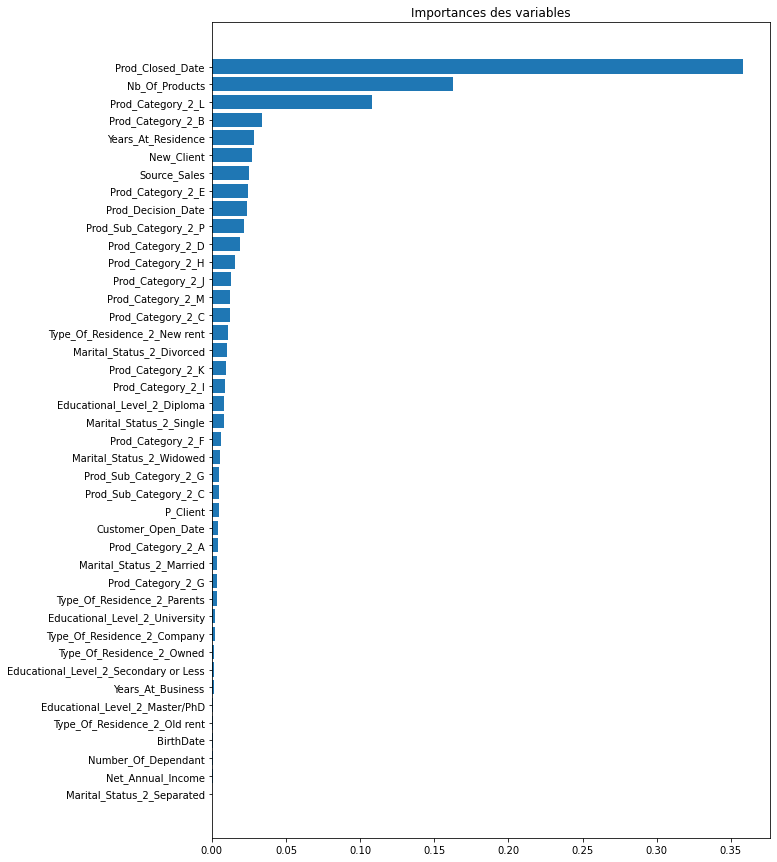

In [0]:
 plt.figure(figsize=(10,15))
plt.title("Importances des variables")
plt.barh(range(X_train.shape[1]), importances_ridge[indices_ridge][::-1], align='center')
plt.yticks(range(X_train.shape[1]), [df_dropped.columns[i] for i in indices_ridge[::-1]])
plt.show()

## 2.7 Logistic Classification

Model with L2 penalization:

In [0]:
t0 = time.time()
logistic = LogisticRegression(max_iter=10000, penalty='l2', solver='sag')
logisticFit = logistic.fit(X_train, Y_train)
print(1-logisticFit.score(X_train, Y_train))
runtimes.append(time.time() - t0)

0.06110594795539037


In [0]:
# prediction error on the test set
result_log = 1-logisticFit.score(X_test,Y_test)
print(result_log) 

Y_pred_logistic = logisticFit.predict(X_test)
resultsTrain.append(1-logisticFit.score(X_train,Y_train))
results.append(result_log)
gini.append(Gini(Y_test,Y_pred_logistic))
results_labels.append('Regr Logist')

0.07713754646840154


Features importance

In [0]:
# Decreasing features importance
importances_log = abs(logistic.coef_[0])
importances_log = importances_log/np.sum(importances_log)
indices_log = np.argsort(importances_log)[::-1]
for f in range(X_train.shape[1]):
    print(df_dropped.columns[indices_log[f]], importances_log[indices_log[f]])

Prod_Closed_Date 0.2524128683565775
Nb_Of_Products 0.12022029685779181
Net_Annual_Income 0.11185955404115247
Prod_Category_2_L 0.06455216072088202
Prod_Category_2_J 0.0637957291270226
Years_At_Residence 0.04065359554159842
New_Client 0.03802266647060396
Prod_Category_2_G 0.03541852406630157
Prod_Category_2_E 0.03417453334837122
Educational_Level_2_Secondary or Less 0.019476440225665078
Customer_Open_Date 0.018961939564268136
Prod_Category_2_H 0.017192956849207384
Prod_Decision_Date 0.01657541922915469
Marital_Status_2_Divorced 0.016517391220259168
Prod_Sub_Category_2_P 0.01648112493567539
Prod_Category_2_K 0.01636657243135082
Prod_Category_2_B 0.013902418872786563
Type_Of_Residence_2_Company 0.010931834681540884
BirthDate 0.009450321202235153
Marital_Status_2_Widowed 0.009291213726793911
Marital_Status_2_Single 0.007272698827780214
Prod_Category_2_M 0.006730635928072599
Prod_Category_2_F 0.006123102320013969
Source_Sales 0.0059781055807076365
Prod_Category_2_A 0.005240733778891231
Year

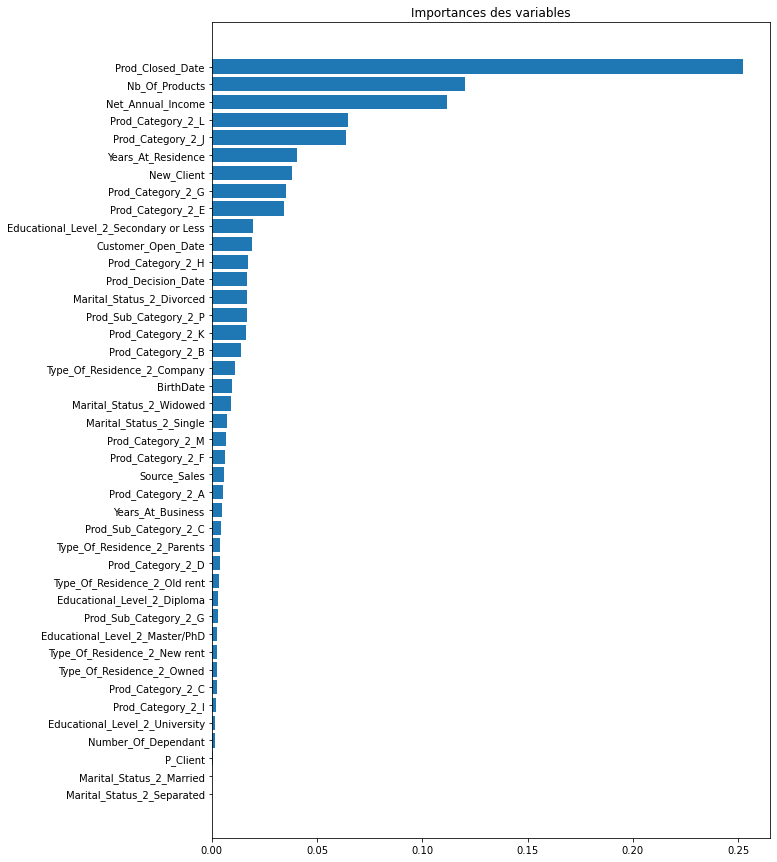

In [0]:
plt.figure(figsize=(10,15))
plt.title("Importances des variables")
plt.barh(range(X_train.shape[1]), importances_log[indices_log][::-1], align='center')
plt.yticks(range(X_train.shape[1]), [df_dropped.columns[i] for i in indices_log[::-1]])
plt.show()

# 3. Machine Learning Models with Engineered Datasets

We compared the performances of our models when trained with different datasets:
- With less covariates (we removed the least important ones in terms of weights in our models)
- Without the outliers
- With a balanced proportion of default payment and non default payment

## 3.1 Training of models with less covariates

We tried to remove the features which had the smaller weights in our various models. We thus keep two different sets of features one with 10 features less than the initial dataset and one with 15 less.
We normalized the datasets obtained after removing the covariates.

### Feature elimination

In [0]:
toRemoveVar = set()
bestVar = set()
listRemove = list(df_dropped.columns[indices_rf[:-5:-1]]) + list(df_dropped.columns[indices_xgb[:-5:-1]]) + list(df_dropped.columns[indices_lgbm[:-5:-1]]) + list(df_dropped.columns[indices_catb[:-5:-1]]) + list(df_dropped.columns[indices_ridge[:-5:-1]]) + list(df_dropped.columns[indices_log[:-5:-1]])
listBest = list(df_dropped.columns[indices_rf[:5]]) + list(df_dropped.columns[indices_xgb[:5]]) + list(df_dropped.columns[indices_lgbm[:5]]) + list(df_dropped.columns[indices_catb[:5]]) + list(df_dropped.columns[indices_ridge[:5]]) + list(df_dropped.columns[indices_log[:5]])

for var in listRemove :
    toRemoveVar.add(var)

for var in listBest :    
    bestVar.add(var)

toRemoveVarBig = toRemoveVar
toRemoveVarSmall = toRemoveVar.difference(bestVar)

In [0]:
df_reduceBig = df_dropped.drop(toRemoveVarSmall, axis=1)
df_reduceSmall = df_dropped.drop(toRemoveVarBig, axis=1)
X_trainB, X_testB, Y_trainB, Y_testB = train_test_split(df_reduceBig, Y, test_size = int(len(df.index)*0.2), random_state=11)
X_trainS, X_testS, Y_trainS, Y_testS = train_test_split(df_reduceSmall, Y, test_size = int(len(df.index)*0.2), random_state=11)

In [0]:
# Normalization

scaler = StandardScaler()  
scaler.fit(X_trainS)  
X_trainS = scaler.transform(X_trainS)  
X_testS = scaler.transform(X_testS)

scaler = StandardScaler()  
scaler.fit(X_trainB)  
X_trainB = scaler.transform(X_trainB)  
X_testB = scaler.transform(X_testB)

### Random Forest

In [0]:
rfS = RandomForestClassifier(n_estimators=81, max_features=9)
rfFitS = rfS.fit(X_trainS, Y_trainS)
result_rfS = 1-rfFitS.score(X_testS, Y_testS)
Y_pred_rfS = rfFitS.predict(X_testS)
resultsRF.append(result_rfS)
giniRF.append(Gini(Y_testS, Y_pred_rfS))
results_labelsRF.append('RFVerySmallData')

rfB = RandomForestClassifier(n_estimators=31, max_features=9)
rfFitB = rfB.fit(X_trainB, Y_trainB)
result_rfB = 1-rfFitB.score(X_testB, Y_testB)
Y_pred_rfB = rfFitB.predict(X_testB)
resultsRF.append(result_rfB)
giniRF.append(Gini(Y_testB, Y_pred_rfB))
results_labelsRF.append('RFSmallData')

### LightGBM

In [0]:
lgbm3 = lightgbm.LGBMClassifier(max_depth = 7)
lgbmFitS = lgbm3.fit(X_trainS, Y_trainS)
result_lgbmS = 1-lgbmFitS.score(X_testS,Y_testS)
Y_pred_lgbmS = lgbmFitS.predict(X_testS)
resultsLGBM.append(result_lgbmS)
giniLGBM.append(Gini(Y_testS, Y_pred_lgbmS))
results_labelsLGBM.append('LGBMSVerySmallData')

lgbm4 = lightgbm.LGBMClassifier(max_depth = 7)
lgbmFitB = lgbm4.fit(X_trainB, Y_trainB)
result_lgbmB = 1-lgbmFitB.score(X_testB,Y_testB)
Y_pred_lgbmB = lgbmFitB.predict(X_testB)
resultsLGBM.append(result_lgbmB)
giniLGBM.append(Gini(Y_testB, Y_pred_lgbmB))
results_labelsLGBM.append('LGBMSmallData')

### Ridge

In [0]:
ridge3 = RidgeClassifier(alpha = (52))
ridgeS = ridge3.fit(X_trainS, Y_trainS)
result_ridgeS = 1-ridgeS.score(X_testS, Y_testS)
Y_pred_ridgeS = ridgeS.predict(X_testS)
resultsRidge.append(result_ridgeS)
giniRidge.append(Gini(Y_testS, Y_pred_ridgeS))
results_labelsRidge.append('RidgeVerySmallData')

ridge4 = RidgeClassifier(alpha = (52))
ridgeB = ridge4.fit(X_trainB, Y_trainB)
result_ridgeB = 1-ridgeB.score(X_testB, Y_testB)
Y_pred_ridgeB = ridgeB.predict(X_testB)
resultsRidge.append(result_ridgeB)
giniRidge.append(Gini(Y_testB, Y_pred_ridgeB))
results_labelsRidge.append('RidgeSmallData')

## 3.2 Training without outliers

We use the Z-score to detect outliers. We use a threshold of -3.5 : 3.5 to detect outliers in the train set.



### Outlier Analysis

In [0]:
# To have comparable results we use a random seed =11 
X_trainOutliers, X_testOutliers, Y_trainOutliers, Y_testOutliers = train_test_split(df_dropped,Y,test_size= int(len(df_dropped.index)*0.2),random_state=11)
X_trainOutliers['Y'] = Y_trainOutliers

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
X_trainOutliers = X_trainOutliers[(np.abs(stats.zscore(X_trainOutliers[['BirthDate', 'Customer_Open_Date',
                                           'Number_Of_Dependant', 'Years_At_Residence',
                                           'Net_Annual_Income', 'Years_At_Business',
                                           'Prod_Decision_Date', 'Nb_Of_Products',
                                           'Prod_Closed_Date']])) < 3.5).all(axis=1)]

In [0]:
Y_trainOutliers = X_trainOutliers['Y']
X_trainOutliers = X_trainOutliers.drop(['Y'], axis=1)

In [0]:
scaler = StandardScaler()  
scaler.fit(X_trainOutliers)  
X_trainOutliers = scaler.transform(X_trainOutliers)  
X_testOutliers = scaler.transform(X_testOutliers)

### Random Forest

In [0]:
rfOutliers = RandomForestClassifier(n_estimators=81, max_features=9)
rfFitOutliers = rfOutliers.fit(X_trainOutliers, Y_trainOutliers)
result_rfOutliers = 1-rfFitOutliers.score(X_testOutliers, Y_testOutliers)
Y_pred_rfOutliers = rfFitOutliers.predict(X_testOutliers)
resultsRF.append(result_rfOutliers)
giniRF.append(Gini(Y_testOutliers, Y_pred_rfOutliers))
results_labelsRF.append('RFOutliers')

### LightGBM

In [0]:
lgbm2 = lightgbm.LGBMClassifier(max_depth = 7)
lgbmFitOutliers = lgbm2.fit(X_trainOutliers, Y_trainOutliers)
result_lgbmOutliers = 1-lgbmFitOutliers.score(X_testOutliers, Y_testOutliers)
Y_pred_lgbmOutliers = lgbmFitOutliers.predict(X_testOutliers)
resultsLGBM.append(result_lgbmOutliers)
giniLGBM.append(Gini(Y_testOutliers, Y_pred_lgbmOutliers))
results_labelsLGBM.append('LGBMOutliers')

### Ridge

In [0]:
ridge2 = RidgeClassifier(alpha = (52))

ridgeOutliers = ridge2.fit(X_trainOutliers, Y_trainOutliers)
result_ridgeOutliers = 1-ridgeOutliers.score(X_testOutliers, Y_testOutliers)
Y_pred_ridgeOutliers = ridgeOutliers.predict(X_testOutliers)
resultsRidge.append(result_ridgeOutliers)
giniRidge.append(Gini(Y_testOutliers, Y_pred_ridgeOutliers))
results_labelsRidge.append('RidgeOutliers')

## 3.3 Training on a rebalanced dataset

As the default payment class were largely under represented, we tried to compensate this bias by transforming the dataset to make it more balanced. To do so, we tried 3 techniques:
- Over representing the default payment class
- Under representing the non default payment class
- Use a combination of both previous techniques

### Rebalancing with SMOTE an Tomek techniques (Over then Under Sampling)

In [0]:
smt = SMOTETomek(ratio='auto');
X_trainBalanced, Y_trainBalanced = smt.fit_sample(X_train, Y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
scaler = StandardScaler()  
scaler.fit(X_trainBalanced)  
X_trainBalanced = scaler.transform(X_trainBalanced)  
X_testBalanced = scaler.transform(X_test)

### Rebalancing with Random Over or Under sampling

In [0]:
ros = RandomOverSampler()
rus = RandomUnderSampler()

X_trainUnder, Y_trainUnder = rus.fit_sample(X_train, Y_train)
X_trainOver, Y_trainOver = ros.fit_sample(X_train, Y_train)

scaler = StandardScaler()  
scaler.fit(X_trainUnder)  
X_trainUnder = scaler.transform(X_trainUnder)  
X_testUnder = scaler.transform(X_test)

scaler = StandardScaler()  
scaler.fit(X_trainOver)  
X_trainOver = scaler.transform(X_trainOver)  
X_testOver = scaler.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Random Forest

In [0]:
rfBalanced = RandomForestClassifier(n_estimators=81, max_features=9)
rfFitBalanced = rfBalanced.fit(X_trainBalanced, Y_trainBalanced)
result_rfBalanced = 1-rfFitBalanced.score(X_testBalanced, Y_test)
Y_pred_rfBalanced = rfFitBalanced.predict(X_testBalanced)
resultsRF.append(result_rfBalanced)
giniRF.append(Gini(Y_test, Y_pred_rfBalanced))
results_labelsRF.append('RFOver&Under')

rfUnder = RandomForestClassifier(n_estimators=81, max_features=9)
rfFitUnder = rfUnder.fit(X_trainUnder, Y_trainUnder)
result_rfUnder = 1-rfFitUnder.score(X_testUnder, Y_test)
Y_pred_rfUnder = rfFitUnder.predict(X_testUnder)
resultsRF.append(result_rfUnder)
giniRF.append(Gini(Y_test, Y_pred_rfUnder))
results_labelsRF.append('RFUnderSampl')

rfOver = RandomForestClassifier(n_estimators=81, max_features=9)
rfFitOver = rfOver.fit(X_trainOver, Y_trainOver)
result_rfOver = 1-rfFitOver.score(X_testOver, Y_test)
Y_pred_rfOver = rfFitOver.predict(X_testOver)
resultsRF.append(result_rfOver)
giniRF.append(Gini(Y_test, Y_pred_rfOver))
results_labelsRF.append('RFOverSampl')

### LightGBM

In [0]:
lgbm2 = lightgbm.LGBMClassifier(max_depth = 7)
lgbmFitBalanced = lgbm2.fit(X_trainBalanced, Y_trainBalanced)
result_lgbmBalanced = 1-lgbmFitBalanced.score(X_testBalanced, Y_test)
Y_pred_lgbmBalanced = lgbmFitBalanced.predict(X_testBalanced)
resultsLGBM.append(result_lgbmBalanced)
giniLGBM.append(Gini(Y_test, Y_pred_lgbmBalanced))
results_labelsLGBM.append('LGBMOver&Under')

lgbm = lightgbm.LGBMClassifier(max_depth = 7)
lgbmFitUnder = lgbm.fit(X_trainUnder, Y_trainUnder)
result_lgbmUnder = 1-lgbmFitUnder.score(X_testUnder, Y_test)
Y_pred_lgbmUnder = lgbmFitUnder.predict(X_testUnder)
resultsLGBM.append(result_lgbmUnder)
giniLGBM.append(Gini(Y_test, Y_pred_lgbmUnder))
results_labelsLGBM.append('LGBMUnderSampl')

lgbm = lightgbm.LGBMClassifier(max_depth = 7)
lgbmFitOver = lgbm.fit(X_trainOver, Y_trainOver)
result_lgbmOver = 1-lgbmFitOver.score(X_testOver, Y_test)
Y_pred_lgbmOver = lgbmFitOver.predict(X_testOver)
resultsLGBM.append(result_lgbmOver)
giniLGBM.append(Gini(Y_test, Y_pred_lgbmOver))
results_labelsLGBM.append('LGBMOverSampl')

### Ridge

In [0]:
ridge2 = RidgeClassifier(alpha = (52))

ridgeBalanced = ridge2.fit(X_trainBalanced, Y_trainBalanced)
result_ridgeBalanced = 1-ridgeBalanced.score(X_testBalanced, Y_test)
Y_pred_ridgeBalanced = ridgeBalanced.predict(X_testBalanced)
resultsRidge.append(result_ridgeBalanced)
giniRidge.append(Gini(Y_test, Y_pred_ridgeBalanced))
results_labelsRidge.append('RidgeOver&Under')

ridgeUnder = ridge.fit(X_trainUnder, Y_trainUnder)
result_ridgeUnder = 1-ridgeUnder.score(X_testUnder, Y_test)
Y_pred_ridgeUnder = ridgeUnder.predict(X_testUnder)
resultsRidge.append(result_ridgeUnder)
giniRidge.append(Gini(Y_test, Y_pred_ridgeUnder))
results_labelsRidge.append('RidgeUnderSampl')

ridgeOver = ridge.fit(X_trainOver, Y_trainOver)
result_ridgeOver = 1-ridgeOver.score(X_testOver, Y_test)
Y_pred_ridgeOver = ridgeOver.predict(X_testOver)
resultsRidge.append(result_ridgeOver)
giniRidge.append(Gini(Y_test, Y_pred_ridgeOver))
results_labelsRidge.append('RidgeOverSampl')

# 4. Results Comparison

## 4.1 Results without major modifications on dataset

### Error on test set

The results on the test set show that the boosting techniques clearly dominate the benchmark with a classification errror under 5%. Though there is no clear difference between LGBM, XGB and CatBoost. Moreover as clients with "Y==1" (default payment clients) represent about 8% of the clients, other metrics are very important to understand how behaves our models and if they classify efficiently the clients with "Y==1".

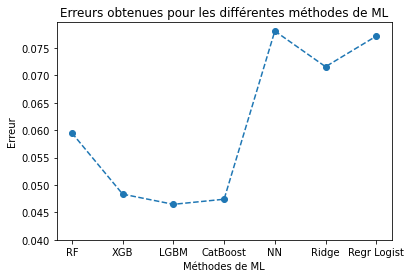

In [0]:
plt.figure()
plt.plot(results_labels, results, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Erreur")
plt.title("Erreurs obtenues pour les différentes méthodes de ML")
plt.ylim(bottom = 0.04)
plt.show()

### Error on train set

The error on the train set shows that RF and the boosting techniques nearly manage to learn the whole dataset. It highlight the fact these techniques can learn a lot of feature and would still be able to learn more if the dataset was larger. It also illustrate an overfitting risk in particular for the random forest techniques whose error on the train set is very close to 0, even though it presents a 6% error on the test set.

On the contrary, Neural Networks, Ridge and Logistic Regression show an error which is close to their error on the train set. Appart from the neural network whose performances could be improved by playing on the network shape, the result on the train and test sets show the limited potential of the ridge and logistic calssification for this problem.

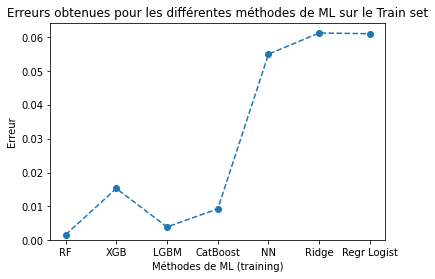

In [0]:
plt.figure()
plt.plot(results_labels, resultsTrain, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML (training)")
plt.ylabel("Erreur")
plt.title("Erreurs obtenues pour les différentes méthodes de ML sur le Train set")
plt.ylim(bottom = 0)
plt.show()

### ROC Curve and AUC

We also used the ROC curve, AUC and Gini's indice to estimate the efficiency of our techniques. In particular an AUC and a Gini's indice close to 1 illustrate good classification performances.

The graph below shows the ROC curve on the test set. We observe that the curve rise quickly to the upper left corner of the figure which illustrate good classification perfromances. Associated with that, AUC (Area Under the Curve) are above 0.9 for every technique and above 0.95 for the boosting techniques.

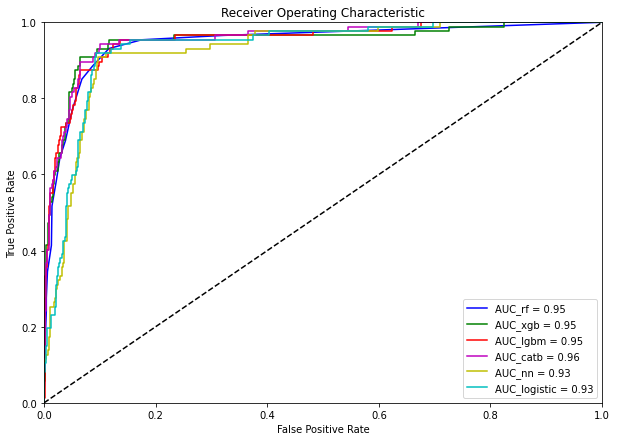

In [0]:
Y_pred_proba_rf = rfFit.predict_proba(X_test)[:,1]
Y_pred_proba_xgb = xgbFit.predict_proba(X_test)[:,1]
Y_pred_proba_lgbm = lgbmFit.predict_proba(X_test)[:,1]
Y_pred_proba_catb = catbFit.predict_proba(X_test)[:,1]
Y_pred_proba_nn = nnetOpt.predict_proba(X_test)[:,1]
Y_pred_proba_logistic = logisticFit.predict_proba(X_test)[:,1]

fpr_rf, tpr_rf, threshold_rf = metrics.roc_curve(Y_test, Y_pred_proba_rf)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)
fpr_xgb, tpr_xgb, threshold_xgb = metrics.roc_curve(Y_test, Y_pred_proba_xgb)
roc_auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)
fpr_lgbm, tpr_lgbm, threshold_lgbm = metrics.roc_curve(Y_test, Y_pred_proba_lgbm)
roc_auc_lgbm = metrics.auc(fpr_lgbm, tpr_lgbm)
fpr_catb, tpr_catb, threshold_catb = metrics.roc_curve(Y_test, Y_pred_proba_catb)
roc_auc_catb = metrics.auc(fpr_catb, tpr_catb)
fpr_nn, tpr_nn, threshold_nn = metrics.roc_curve(Y_test, Y_pred_proba_nn)
roc_auc_nn = metrics.auc(fpr_nn, tpr_nn)
fpr_logistic, tpr_logistic, threshold_logistic = metrics.roc_curve(Y_test, Y_pred_proba_logistic)
roc_auc_logistic = metrics.auc(fpr_logistic, tpr_logistic)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rf, tpr_rf, 'b', label = 'AUC_rf = %0.2f' % roc_auc_rf)
plt.plot(fpr_xgb, tpr_xgb, 'g', label = 'AUC_xgb = %0.2f' % roc_auc_xgb)
plt.plot(fpr_lgbm, tpr_lgbm, 'r', label = 'AUC_lgbm = %0.2f' % roc_auc_lgbm)
plt.plot(fpr_catb, tpr_catb, 'm', label = 'AUC_catb = %0.2f' % roc_auc_catb)
plt.plot(fpr_nn, tpr_nn, 'y', label = 'AUC_nn = %0.2f' % roc_auc_nn)
plt.plot(fpr_logistic, tpr_logistic, 'c', label = 'AUC_logistic = %0.2f' % roc_auc_logistic)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Gini Indice

We used also compared Gini indices. Once again it highlighted the better performances of the boosting techniques, which all had Gini indices around 0.5 while the other techniques indices were clearly lower. 

However a Gini indice of 0.5 shows that there is still room for improvement on our model, probably because the default payment class is largely under represented.

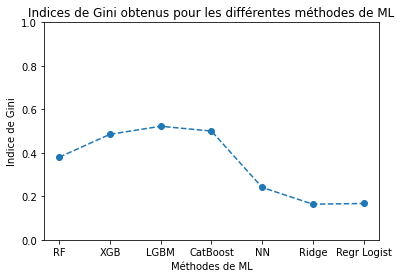

In [0]:
plt.figure()
plt.plot(results_labels, gini, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Indice de Gini")
plt.title("Indices de Gini obtenus pour les différentes méthodes de ML")
plt.ylim(bottom = 0, top = 1)
plt.show()

### Confusion Matrix

As ou Dataset is heavily unbalanced, the Confusion Matrix gives us important information about our model performances. It shows us that all the techniques tend to classify very often clients as "non default payment" which is quite logical as the "non default payment" are far more numerous in the training set. More specifically, we have the confirmation that boosting techniques & RF perform better than ridge, logistic classification and neural network, as they have nearly the same rates of True Negative but the rate of True Positive is far lower for NN, ridge and logistic regression than for the bagging and boosting techniques.

Consequently the Ridge, NN and Logistic regression have produced results of poorer quality for every metric considered, which lead us to choose a boosting technique or RF for our final model.

Let's now look closer at the results of the bagging and boosting techniques. Their classification leads to 91% of True Negative when 92% of the test data is actually Negative (they all have 1% False Positive). So the classification of Negative clients (non default payment, Y==0) is well done. 

Studying the True Positive and False Negative enables us to make a difference between the boosting techniques and the random forests. Indeed, sensitivities are:
- 54% for LGBM
- 53% for Catboost and XGBoost
- 46% for RF

Thus the reuslt of the boosting are more promising than the one of the random forest. Still with a sensitivity close to 50% percents for these techniques there is room for improvement. Consequently to solve this problem of classification of default payment client, we tried to modify the dataset in several ways.

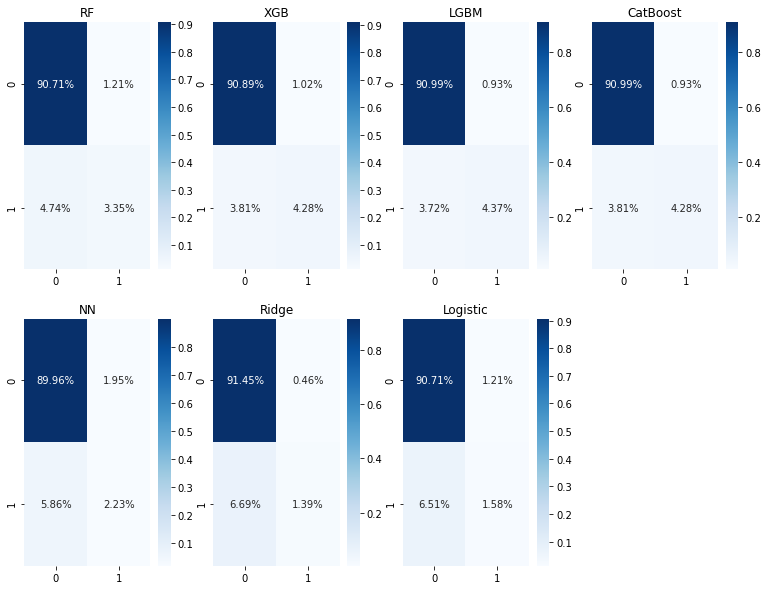

In [0]:
plt.figure(figsize=(13,10))

plt.subplot(2, 4, 1)
plt.title('RF')
plt.ylabel('True Y label')
cf_matrix_rf = confusion_matrix(Y_test, Y_pred_rf)
sns.heatmap(cf_matrix_rf/np.sum(cf_matrix_rf), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 2)
plt.title('XGB')
cf_matrix_xgb = confusion_matrix(Y_test, Y_pred_xgb)
sns.heatmap(cf_matrix_xgb/np.sum(cf_matrix_xgb), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 3)
plt.title('LGBM')
cf_matrix_lgbm = confusion_matrix(Y_test, Y_pred_lgbm)
sns.heatmap(cf_matrix_lgbm/np.sum(cf_matrix_lgbm), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 4)
plt.title('CatBoost')
cf_matrix_catb = confusion_matrix(Y_test, Y_pred_catb)
sns.heatmap(cf_matrix_catb/np.sum(cf_matrix_catb), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 5)
plt.ylabel('True Y label')
plt.xlabel('Predicted Y label')
plt.title('NN')
cf_matrix_nn = confusion_matrix(Y_test, Y_pred_nn)
sns.heatmap(cf_matrix_nn/np.sum(cf_matrix_nn), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 6)
plt.xlabel('Predicted Y label')
plt.title('Ridge')
cf_matrix_ridge = confusion_matrix(Y_test, Y_pred_ridge)
sns.heatmap(cf_matrix_ridge/np.sum(cf_matrix_ridge), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 7)
plt.xlabel('Predicted Y label')
plt.title('Logistic')
cf_matrix_logistic = confusion_matrix(Y_test, Y_pred_logistic)
sns.heatmap(cf_matrix_logistic/np.sum(cf_matrix_logistic), fmt='.2%',annot=True, cmap='Blues')

### Learning times

We also compared the learning times of our models. Even though the training is only done once we thought it would be interesting to compare this datapoint as it highlights large disparities between the techniques and also because the train set is limited to around 5000 thousands data, but one may also be interesting in training on larger datasets for which training could be more important.

This comparison sets appart two techniques whose training time are largely above the others: Neural Networks and CatBoost

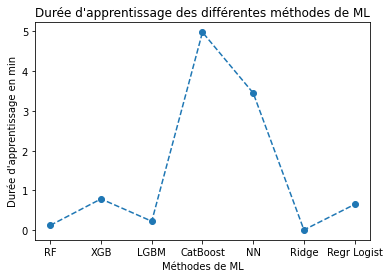

In [0]:
plt.figure()
plt.plot(results_labels, runtimes, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Durée d'apprentissage en min")
plt.title("Durée d'apprentissage des différentes méthodes de ML")
plt.show()

## 4.2 Results with resampling, feature selection or without outliers

In this part we present the performances of several techniques when trained on modififed datasets. In particular they were trained on datasets:
- with the 15 less important removed (named after Very Small Data)
- with the 10 less important removed (named after Small Data)
- without the outliers (named after Outliers)
- with a more balanced proportion of Default payment class (Y==1) using
    - a combination of Over sampling and Under sampling (named after Balanced)
    - Over sampling only (named after Over)
    - Under sampling only (named after Under)

We display the results for 3 methods RF, LGBM and Ridge to have an overview of how would the ML methods behave. Yet while choosing our final and best model we keep in mind that LGBM had clearly better results when trained on the initial dataset.


### Error on test set

The LGBM model still outperforms the other ones no matter how engineered are the datasets. The performances are slightly better when LGBM is trained on the initial dataset. But as explained earlier, the real interest of training our engineered datasets is to try to solve the problem of predicting well the default payment class which cannot be efficiently detected with the classification error. We will be able to see this with the Confusion Matrix. 

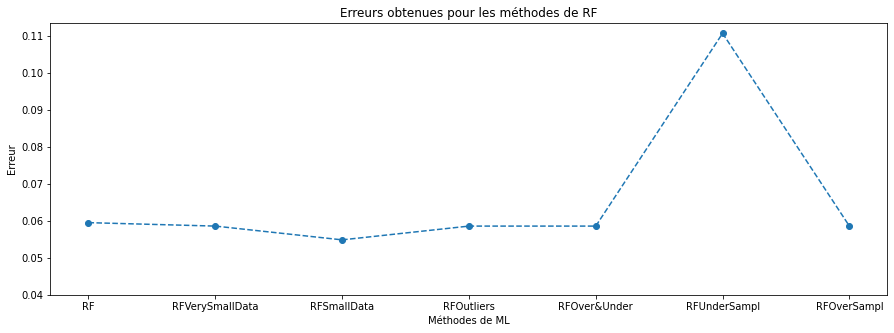

In [0]:
plt.figure(figsize=(15,5))
plt.plot(results_labelsRF, resultsRF, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Erreur")
plt.title("Erreurs obtenues pour les méthodes de RF")
plt.ylim(bottom = 0.04)
plt.show()

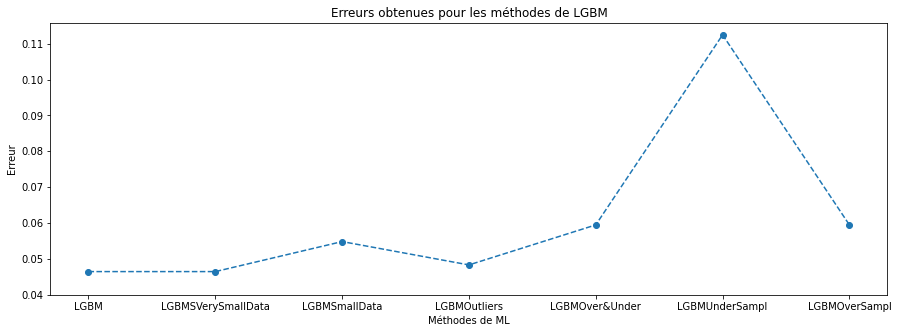

In [0]:
plt.figure(figsize=(15,5))
plt.plot(results_labelsLGBM, resultsLGBM, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Erreur")
plt.title("Erreurs obtenues pour les méthodes de LGBM")
plt.ylim(bottom = 0.04)
plt.show()

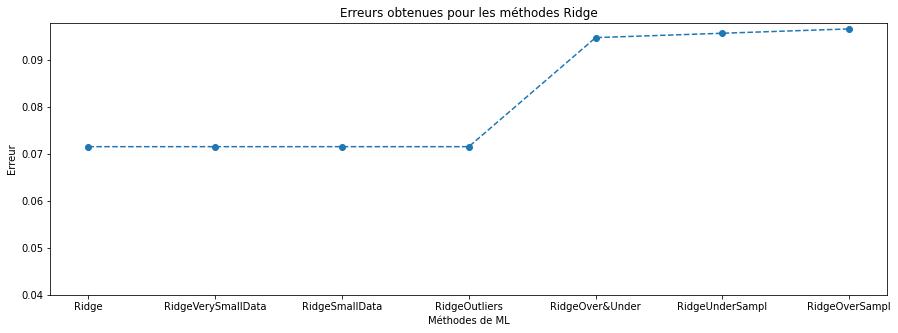

In [0]:
plt.figure(figsize=(15,5))
plt.plot(results_labelsRidge, resultsRidge, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Erreur")
plt.title("Erreurs obtenues pour les méthodes Ridge")
plt.ylim(bottom = 0.04)
plt.show()

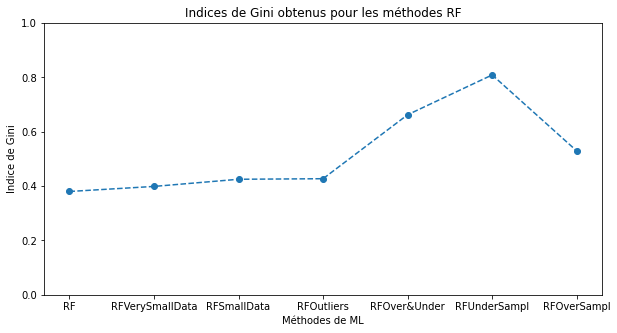

In [0]:
plt.figure(figsize=(10,5))
plt.plot(results_labelsRF, giniRF, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Indice de Gini")
plt.title("Indices de Gini obtenus pour les méthodes RF")
plt.ylim(bottom = 0, top = 1)
plt.show()

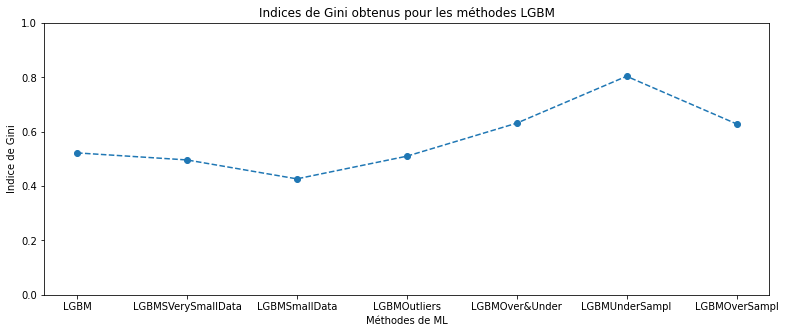

In [0]:
plt.figure(figsize=(13,5))
plt.plot(results_labelsLGBM, giniLGBM, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Indice de Gini")
plt.title("Indices de Gini obtenus pour les méthodes LGBM")
plt.ylim(bottom = 0, top = 1)
plt.show()

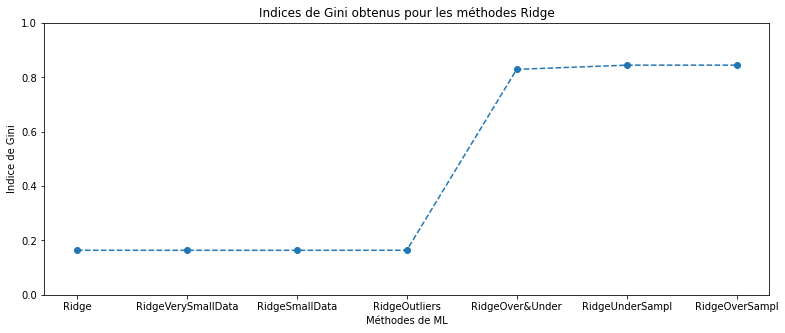

In [0]:
plt.figure(figsize=(13,5))
plt.plot(results_labelsRidge, giniRidge, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Indice de Gini")
plt.title("Indices de Gini obtenus pour les méthodes Ridge")
plt.ylim(bottom = 0, top = 1)
plt.show()

### ROC curve


No matter on which dataset was trained the LGBM its AUC remains very close to 0.95 and the shape of the curve stuck in the upper left side of the plot which is very positive. To choose our final model, we will more rely on the Confusion Matrix.

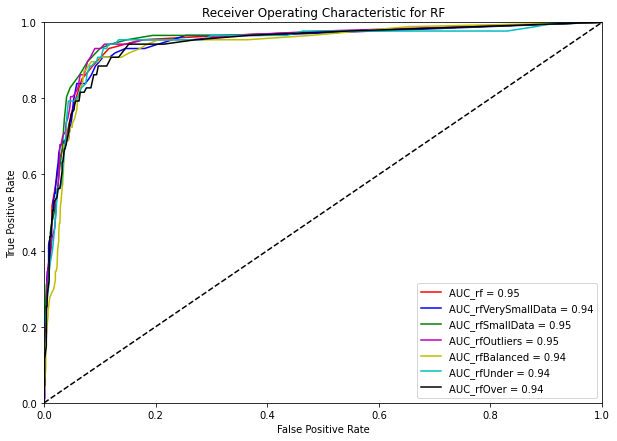

In [0]:
Y_pred_proba_rf = rfFit.predict_proba(X_test)[:,1]
Y_pred_proba_rfS = rfFitS.predict_proba(X_testS)[:,1]
Y_pred_proba_rfB = rfFitB.predict_proba(X_testB)[:,1]
Y_pred_proba_rfOutliers = rfFitOutliers.predict_proba(X_testOutliers)[:,1]
Y_pred_proba_rfBalanced = rfFitBalanced.predict_proba(X_testBalanced)[:,1]
Y_pred_proba_rfUnder = rfFitUnder.predict_proba(X_testUnder)[:,1]
Y_pred_proba_rfOver = rfFitOver.predict_proba(X_testOver)[:,1]

fpr_rf, tpr_rf, threshold_rf = metrics.roc_curve(Y_test, Y_pred_proba_rf)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)
fpr_rfS, tpr_rfS, threshold_rfS = metrics.roc_curve(Y_testS, Y_pred_proba_rfS)
roc_auc_rfS = metrics.auc(fpr_rfS, tpr_rfS)
fpr_rfB, tpr_rfB, threshold_rfB = metrics.roc_curve(Y_testB, Y_pred_proba_rfB)
roc_auc_rfB = metrics.auc(fpr_rfB, tpr_rfB)
fpr_rfOutliers, tpr_rfOutliers, threshold_rfOutliers = metrics.roc_curve(Y_testOutliers, Y_pred_proba_rfOutliers)
roc_auc_rfOutliers = metrics.auc(fpr_rfOutliers, tpr_rfOutliers)
fpr_rfBalanced, tpr_rfBalanced, threshold_rfBalanced = metrics.roc_curve(Y_test, Y_pred_proba_rfBalanced)
roc_auc_rfBalanced = metrics.auc(fpr_rfBalanced, tpr_rfBalanced)
fpr_rfUnder, tpr_rfUnder, threshold_rfUnder = metrics.roc_curve(Y_test, Y_pred_proba_rfUnder)
roc_auc_rfUnder = metrics.auc(fpr_rfUnder, tpr_rfUnder)
fpr_rfOver, tpr_rfOver, threshold_rfOver = metrics.roc_curve(Y_test, Y_pred_proba_rfOver)
roc_auc_rfOver = metrics.auc(fpr_rfOver, tpr_rfOver)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic for RF')
plt.plot(fpr_rf, tpr_rf, 'r', label = 'AUC_rf = %0.2f' % roc_auc_rf)
plt.plot(fpr_rfS, tpr_rfS, 'b', label = 'AUC_rfVerySmallData = %0.2f' % roc_auc_rfS)
plt.plot(fpr_rfB, tpr_rfB, 'g', label = 'AUC_rfSmallData = %0.2f' % roc_auc_rfB)
plt.plot(fpr_rfOutliers, tpr_rfOutliers, 'm', label = 'AUC_rfOutliers = %0.2f' % roc_auc_rfOutliers)
plt.plot(fpr_rfBalanced, tpr_rfBalanced, 'y', label = 'AUC_rfBalanced = %0.2f' % roc_auc_rfBalanced)
plt.plot(fpr_rfUnder, tpr_rfUnder, 'c', label = 'AUC_rfUnder = %0.2f' % roc_auc_rfUnder)
plt.plot(fpr_rfOver, tpr_rfOver, 'black', label = 'AUC_rfOver = %0.2f' % roc_auc_rfOver)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

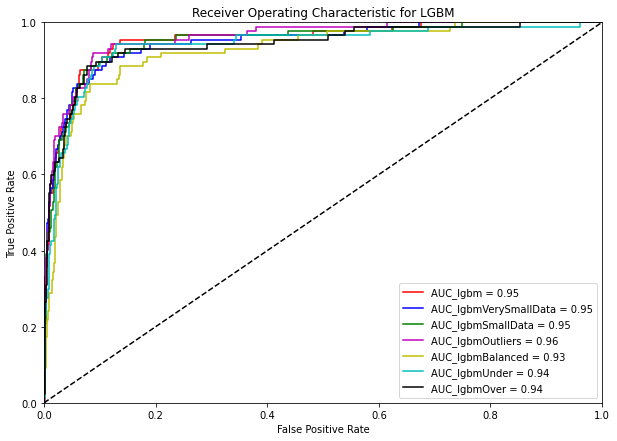

In [0]:
Y_pred_proba_lgbm = lgbmFit.predict_proba(X_test)[:,1]
Y_pred_proba_lgbmS = lgbmFitS.predict_proba(X_testS)[:,1]
Y_pred_proba_lgbmB = lgbmFitB.predict_proba(X_testB)[:,1]
Y_pred_proba_lgbmOutliers = lgbmFitOutliers.predict_proba(X_testOutliers)[:,1]
Y_pred_proba_lgbmBalanced = lgbmFitBalanced.predict_proba(X_testBalanced)[:,1]
Y_pred_proba_lgbmUnder = lgbmFitUnder.predict_proba(X_testUnder)[:,1]
Y_pred_proba_lgbmOver = lgbmFitOver.predict_proba(X_testOver)[:,1]

fpr_lgbm, tpr_lgbm, threshold_lgbm = metrics.roc_curve(Y_test, Y_pred_proba_lgbm)
roc_auc_lgbm = metrics.auc(fpr_lgbm, tpr_lgbm)
fpr_lgbmS, tpr_lgbmS, threshold_lgbmS = metrics.roc_curve(Y_testS, Y_pred_proba_lgbmS)
roc_auc_lgbmS = metrics.auc(fpr_lgbmS, tpr_lgbmS)
fpr_lgbmB, tpr_lgbmB, threshold_lgbmB = metrics.roc_curve(Y_testB, Y_pred_proba_lgbmB)
roc_auc_lgbmB = metrics.auc(fpr_lgbmB, tpr_lgbmB)
fpr_lgbmOutliers, tpr_lgbmOutliers, threshold_lgbmOutliers = metrics.roc_curve(Y_testOutliers, Y_pred_proba_lgbmOutliers)
roc_auc_lgbmOutliers = metrics.auc(fpr_lgbmOutliers, tpr_lgbmOutliers)
fpr_lgbmBalanced, tpr_lgbmBalanced, threshold_lgbmBalanced = metrics.roc_curve(Y_test, Y_pred_proba_lgbmBalanced)
roc_auc_lgbmBalanced = metrics.auc(fpr_lgbmBalanced, tpr_lgbmBalanced)
fpr_lgbmUnder, tpr_lgbmUnder, threshold_lgbmUnder = metrics.roc_curve(Y_test, Y_pred_proba_lgbmUnder)
roc_auc_lgbmUnder = metrics.auc(fpr_lgbmUnder, tpr_lgbmUnder)
fpr_lgbmOver, tpr_lgbmOver, threshold_lgbmOver = metrics.roc_curve(Y_test, Y_pred_proba_lgbmOver)
roc_auc_lgbmOver = metrics.auc(fpr_lgbmOver, tpr_lgbmOver)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic for LGBM')
plt.plot(fpr_lgbm, tpr_lgbm, 'r', label = 'AUC_lgbm = %0.2f' % roc_auc_lgbm)
plt.plot(fpr_lgbmS, tpr_lgbmS, 'b', label = 'AUC_lgbmVerySmallData = %0.2f' % roc_auc_lgbmS)
plt.plot(fpr_lgbmB, tpr_lgbmB, 'g', label = 'AUC_lgbmSmallData = %0.2f' % roc_auc_lgbmB)
plt.plot(fpr_lgbmOutliers, tpr_lgbmOutliers, 'm', label = 'AUC_lgbmOutliers = %0.2f' % roc_auc_lgbmOutliers)
plt.plot(fpr_lgbmBalanced, tpr_lgbmBalanced, 'y', label = 'AUC_lgbmBalanced = %0.2f' % roc_auc_lgbmBalanced)
plt.plot(fpr_lgbmUnder, tpr_lgbmUnder, 'c', label = 'AUC_lgbmUnder = %0.2f' % roc_auc_lgbmUnder)
plt.plot(fpr_lgbmOver, tpr_lgbmOver, 'black', label = 'AUC_lgbmOver = %0.2f' % roc_auc_lgbmOver)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Confusion Matrix

From the LGBM confusion matrices we can see that the quality of the classification default payment is increased only with engineered datasets tackling directly the problem of under representation of the class Y == 1.

First we can see that while undersampling our dataset (reducing the proportion of the class Y==0) the classification of the class Y==1 is the best with a sensitivity of 91%. It's overall classification error is of 11% far above the average rate of default payment client user. This means that one should use this model only if its top priority is to detect default payment clients. As we are considering default payment, this is probably the point of view of bankers or insurance workers.

If we adopt a more balanced point of view between trying to classify well both kinds of clients, the more interesting models are the models trained on the "Balanced dataset" (with Over and Under sampling) and the "Oversampling dataset". Indeed both theses techniques present very similar confusion matrix with sensitivities of 66% and 68%. Their overall classification is also similar. As the scores of LGBM trained on the over and under sampled dataset are slighlty better (classification error and Gini indice) we would choose this model.

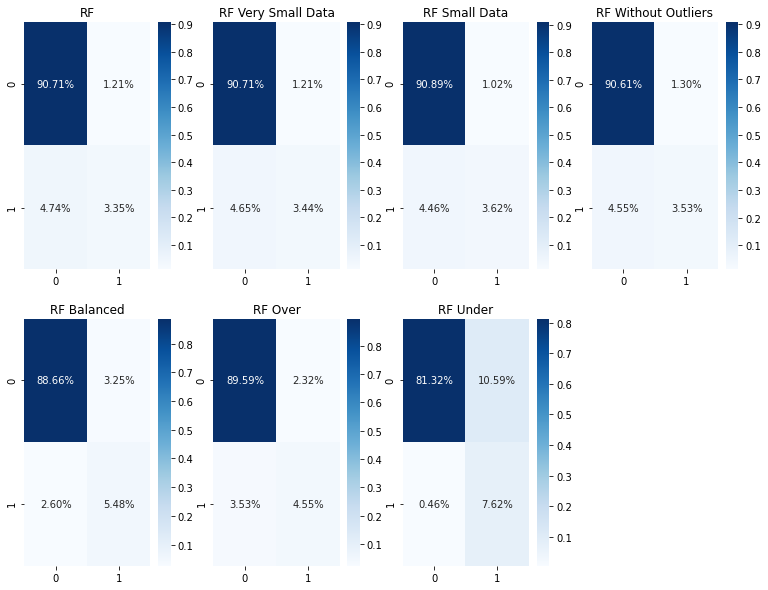

In [0]:
plt.figure(figsize=(13,10))

plt.subplot(2, 4, 1)
plt.title('RF')
cf_matrix_rf = confusion_matrix(Y_test, Y_pred_rf)
sns.heatmap(cf_matrix_rf/np.sum(cf_matrix_rf), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 2)
plt.title('RF Very Small Data')
cf_matrix_rfS = confusion_matrix(Y_testS, Y_pred_rfS)
sns.heatmap(cf_matrix_rfS/np.sum(cf_matrix_rfS), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 3)
plt.title('RF Small Data')
cf_matrix_rfB = confusion_matrix(Y_testB, Y_pred_rfB)
sns.heatmap(cf_matrix_rfB/np.sum(cf_matrix_rfB), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 4)
plt.title('RF Without Outliers')
cf_matrix_rfOutliers = confusion_matrix(Y_testOutliers, Y_pred_rfOutliers)
sns.heatmap(cf_matrix_rfOutliers/np.sum(cf_matrix_rfOutliers), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 5)
plt.title('RF Balanced')
cf_matrix_rfBalanced = confusion_matrix(Y_test, Y_pred_rfBalanced)
sns.heatmap(cf_matrix_rfBalanced/np.sum(cf_matrix_rfBalanced), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 6)
plt.title('RF Over')
cf_matrix_rfOver = confusion_matrix(Y_test, Y_pred_rfOver)
sns.heatmap(cf_matrix_rfOver/np.sum(cf_matrix_rfOver), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 7)
plt.title('RF Under')
cf_matrix_rfUnder = confusion_matrix(Y_test, Y_pred_rfUnder)
sns.heatmap(cf_matrix_rfUnder/np.sum(cf_matrix_rfUnder), fmt='.2%',annot=True, cmap='Blues')

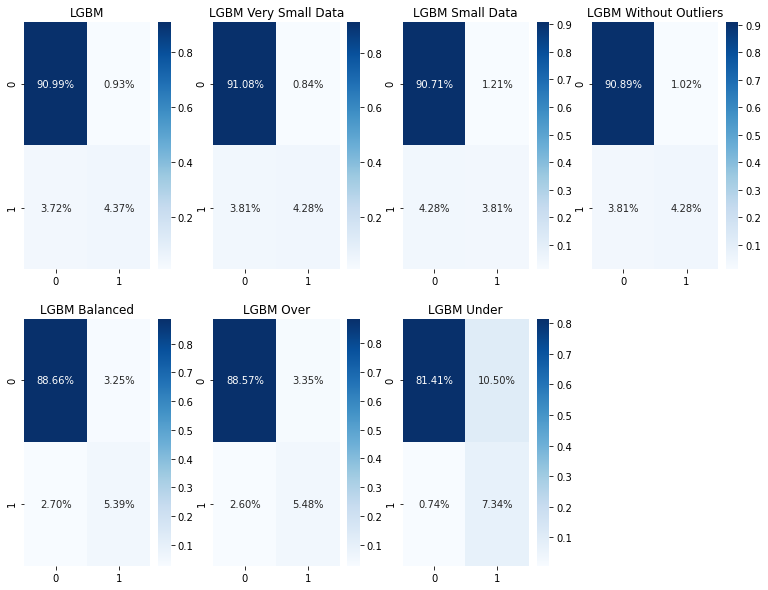

In [0]:
plt.figure(figsize=(13,10))

plt.subplot(2, 4, 1)
plt.title('LGBM')
cf_matrix_lgbm = confusion_matrix(Y_test, Y_pred_lgbm)
sns.heatmap(cf_matrix_lgbm/np.sum(cf_matrix_lgbm), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 2)
plt.title('LGBM Very Small Data')
cf_matrix_lgbmS = confusion_matrix(Y_testS, Y_pred_lgbmS)
sns.heatmap(cf_matrix_lgbmS/np.sum(cf_matrix_lgbmS), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 3)
plt.title('LGBM Small Data')
cf_matrix_lgbmB = confusion_matrix(Y_testB, Y_pred_lgbmB)
sns.heatmap(cf_matrix_lgbmB/np.sum(cf_matrix_lgbmB), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 4)
plt.title('LGBM Without Outliers')
cf_matrix_lgbmOutliers = confusion_matrix(Y_testOutliers, Y_pred_lgbmOutliers)
sns.heatmap(cf_matrix_lgbmOutliers/np.sum(cf_matrix_lgbmOutliers), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 5)
plt.title('LGBM Balanced')
cf_matrix_lgbmBalanced = confusion_matrix(Y_test, Y_pred_lgbmBalanced)
sns.heatmap(cf_matrix_lgbmBalanced/np.sum(cf_matrix_lgbmBalanced), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 6)
plt.title('LGBM Over')
cf_matrix_lgbmOver = confusion_matrix(Y_test, Y_pred_lgbmOver)
sns.heatmap(cf_matrix_lgbmOver/np.sum(cf_matrix_lgbmOver), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 7)
plt.title('LGBM Under')
cf_matrix_lgbmUnder = confusion_matrix(Y_test, Y_pred_lgbmUnder)
sns.heatmap(cf_matrix_lgbmUnder/np.sum(cf_matrix_lgbmUnder), fmt='.2%',annot=True, cmap='Blues')

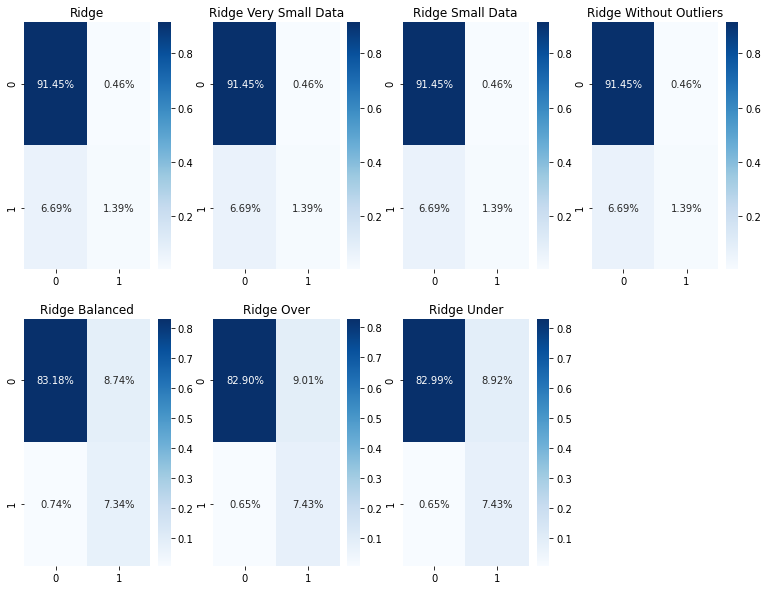

In [0]:
plt.figure(figsize=(13,10))

plt.subplot(2, 4, 1)
plt.title('Ridge')
cf_matrix_ridge = confusion_matrix(Y_test, Y_pred_ridge)
sns.heatmap(cf_matrix_ridge/np.sum(cf_matrix_ridge), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 2)
plt.title('Ridge Very Small Data')
cf_matrix_ridgeS = confusion_matrix(Y_testS, Y_pred_ridgeS)
sns.heatmap(cf_matrix_ridgeS/np.sum(cf_matrix_ridgeS), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 3)
plt.title('Ridge Small Data')
cf_matrix_ridgeB = confusion_matrix(Y_testB, Y_pred_ridgeB)
sns.heatmap(cf_matrix_ridgeB/np.sum(cf_matrix_ridgeB), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 4)
plt.title('Ridge Without Outliers')
cf_matrix_ridgeOutliers = confusion_matrix(Y_testOutliers, Y_pred_ridgeOutliers)
sns.heatmap(cf_matrix_ridgeOutliers/np.sum(cf_matrix_ridgeOutliers), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 5)
plt.title('Ridge Balanced')
cf_matrix_ridgeBalanced = confusion_matrix(Y_test, Y_pred_ridgeBalanced)
sns.heatmap(cf_matrix_ridgeBalanced/np.sum(cf_matrix_ridgeBalanced), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 6)
plt.title('Ridge Over')
cf_matrix_ridgeOver = confusion_matrix(Y_test, Y_pred_ridgeOver)
sns.heatmap(cf_matrix_ridgeOver/np.sum(cf_matrix_ridgeOver), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 7)
plt.title('Ridge Under')
cf_matrix_ridgeUnder = confusion_matrix(Y_test, Y_pred_ridgeUnder)
sns.heatmap(cf_matrix_ridgeUnder/np.sum(cf_matrix_ridgeUnder), fmt='.2%',annot=True, cmap='Blues')

## 4.3 Conclusion

In this project we have trained and compared several ML techniques. To do so, we first proceeded by preparing our dataset looking at the different features, then split the dataset into train and test sets and scaled the quantitative variables. After that, we trained different models on our dataset using cross validation to tune the hyper parameters. We then compared the results of our different models on the test set using different metrics: 
- classification error
- ROC curve and AUC
- Gini indice
- Confusion Matrix

The main challenge of this contests was that one of the two classes we had to predict was largely under represented (about 8% of the total data). Thus we tried to train our models on more engineered dataset to make them classify better the class Y==1. In particular, under sampling the class Y==0 or over sampling the class Y==1 show promising results.

After comparing the model performances on the different metrcis and when trained on the different dataset we would finally recommend using:
- the LGBM model trained on the dataset tuned with Over and Uner sampling
- the LGBM model trained on the dataset tuned only with Under sampling if the priority of the user is to detect the default payment client at the cost of classifying wrongly more some non default payment user. 